In [ ]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import PReLU
from keras.models import model_from_json, load_model
import json
%matplotlib inline



import os
from keras.models import model_from_json
model_file_path = r'C:\Users\Legion\Desktop\New folder\model'

epoch_list = []
loss_list = []
win_rate_list = []


In [ ]:

# Define the function to load the model and its weights
def load_model_and_weights(model_file_path):
    h5file = model_file_path + ".h5"
    json_file = model_file_path + ".json"

    if os.path.isfile(h5file) and os.path.isfile(json_file):
        try:
            # Load the model architecture from the JSON file
            with open(json_file, "r") as json_file:
                model_json = json.load(json_file)
                model = model_from_json(model_json)

            # Load the model weights from the H5 file
            model.load_weights(h5file)
            print("Model and weights loaded successfully!")
            return model
        except Exception as e:
            print("Error loading model and weights:", str(e))
            return None
    else:
        print("Model and weights files do not exist.")
        return None

    # Try to load the model and weights
loaded_model = load_model_and_weights(model_file_path)

if loaded_model is not None:
    # The model and weights were loaded successfully, you can use 'loaded_model' in your code.
    print("Model summary:")
    loaded_model.summary()
else:
    # Handle the case when the model couldn't be loaded
    print("Model and weights could not be loaded.")



In [ ]:

maze = np.array([
    [1., 0., 1., 1., 1., 1. ],
    [1., 0., 1., 1., 0., 0. ],
    [1., 0., 1., 1., 1., 1. ],
    [1., 1., 1., 0., 1., 0. ],
    [0., 0., 1., 0., 1., 1. ],
    [1., 1., 1., 1., 1., 1. ]
])

visited_mark = 0.6
agent_mark = 0.3
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

epsilon = 0.2


In [ ]:
class Qmaze(object):
    def __init__(self, maze, agent=(0, 0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows - 1, ncols - 1)
        self.free_cells = [(r, c) for r in range(nrows) for c in range(ncols) if self._maze[r, c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not agent in self.free_cells:
            raise Exception("Invalid agent Location: must sit on a free cell")
        self.reset(agent)

    def reset(self, agent):
        self.agent = agent
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = agent
        self.maze[row, col] = agent_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.2 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = agent_row, agent_col, mode = self.state

        if self.maze[agent_row, agent_col] > 0.0:
            self.visited.add((agent_row, agent_col))

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:
            mode = 'invalid'

        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        agent_row, agent_col, mode = self.state
        nrows, ncols = self.maze.shape
        if agent_row == nrows - 1 and agent_col == ncols - 1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (agent_row, agent_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return 0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0
        row, col, valid = self.state
        canvas[row, col] = agent_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        agent_row, agent_col, mode = self.state
        nrows, ncols = self.maze.shape
        if agent_row == nrows - 1 and agent_col == ncols - 1:
            return 'win'
        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, _ = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        if row == nrows - 1:
            actions.remove(3)
        if col == 0:
            actions.remove(0)
        if col == ncols - 1:
            actions.remove(2)
        if row > 0 and self.maze[row - 1, col] == 0.0:
            actions.remove(1)
        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:
            actions.remove(3)
        if col > 0 and self.maze[row, col - 1] == 0.0:
            actions.remove(0)
        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:
            actions.remove(2)
        return actions


In [ ]:

# Define the Experience class for replay memory
class Experience(object):
    def __init__(self, model, max_memory=1000, discount=0.97):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, next_envstate, game_over = self.memory[j]
            inputs[i:i + 1] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            Q_sa = np.max(self.predict(next_envstate))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:

def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 100)
    max_memory = opt.get('max_memory', 100)
    data_size = opt.get('data_size', 40)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from the numpy array: maze
    qmaze = Qmaze(maze)

    # Initialize the experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size // 2   # history window size
    win_rate = 0.0
    imctr = 1

    # Define a function to visualize the maze
    def visualize_maze(qmaze):
        plt.grid('on')
        nrows, ncols = qmaze.maze.shape
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, nrows, 1))
        ax.set_yticks(np.arange(0.5, ncols, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        canvas = np.copy(qmaze.maze)
        for row, col in qmaze.visited:
            canvas[row, col] = 0.6
        agent_row, agent_col, _ = qmaze.state
        canvas[agent_row, agent_col] = 0.3   # agent cell
        canvas[nrows - 1, ncols - 1] = 0.9  # target cell
        img = plt.imshow(canvas, interpolation='none', cmap='gray')
        plt.pause(0.01)

    # Modify the training loop to visualize the maze
    for epoch in range(n_epoch):
        loss = 0.0
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        game_over = False

        visualize_maze(qmaze)  # Initial visualization

        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            prev_envstate = qmaze.observe()
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            envstate, reward, game_status = qmaze.act(action)

            action_str = actions_dict[action]
            print("Action: {}, Reward: {}".format(action_str, reward))

            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)

            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)
            
               
            # Append statistics for this epoch
            epoch_list.append(epoch)
            loss_list.append(loss)
            win_rate_list.append(win_rate)

            visualize_maze(qmaze)  # Visualize at each step

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch - 1, loss, len(experience.memory), sum(win_history), win_rate, t))

        if win_rate > 0.9:
            epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and qmaze.game_status() == 'win':
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break


    
    # Append statistics for this epoch
    epoch_list.append(epoch)
    loss_list.append(loss)
    win_rate_list.append(win_rate)

    plt.figure(figsize=(12, 6))

    # Chart 1: Loss over epochs
    plt.subplot(121)
    plt.plot(epoch_list, loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    
    # Chart 2: Win rate over epochs
    plt.subplot(122)
    plt.plot(epoch_list, win_rate_list)
    plt.xlabel('Epoch')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Over Epochs')
    
    # Display the charts
    plt.tight_layout()
    plt.show()
    
    # Save the trained model weights and architecture, which will be used by the visualization code
    
   # model_file = os.path.join(model_directory, 'model1.h5')
    # Save the entire model, including architecture and weights
    

    h5file = model_file_path + ".h5"
    kerasfile = model_file_path + ".keras"
    json_file = model_file_path + ".json"
    model.save_weights(h5file, overwrite=True)
    model.save(kerasfile, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('Files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

weights_file = r'C:\Users\Legion\Desktop\New folder\model1.h5'

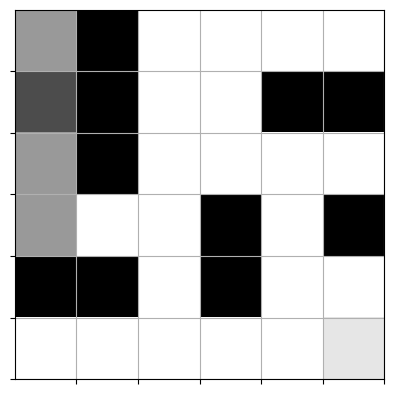

Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


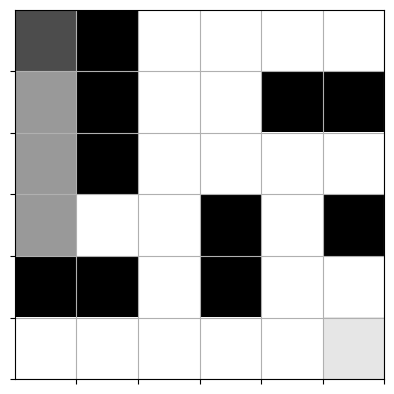

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


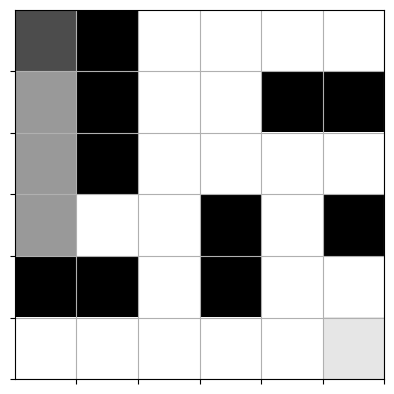

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


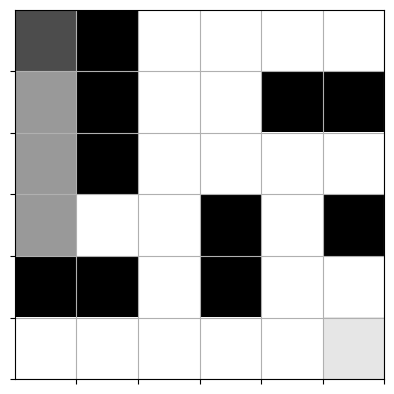

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


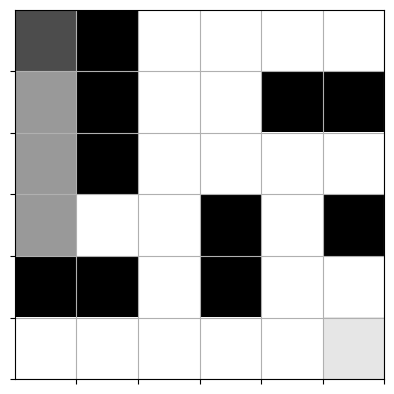

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


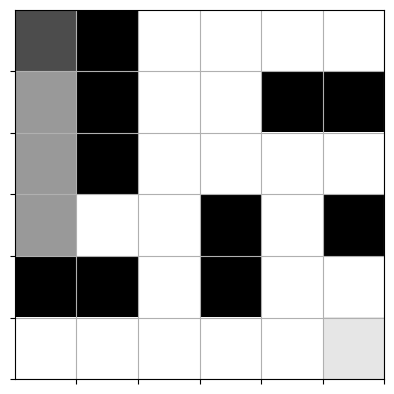

1/1 [==============================] - 0s 13ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


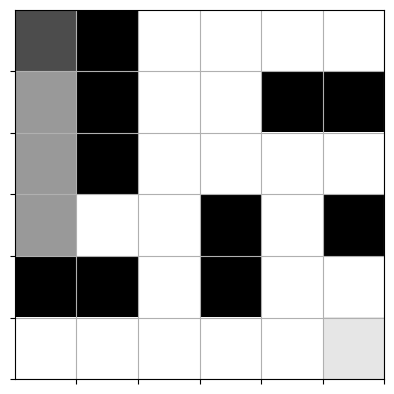

1/1 [==============================] - 0s 13ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


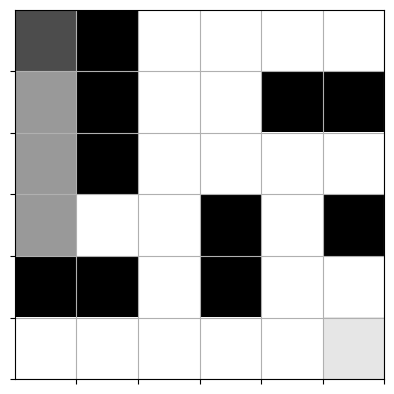

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


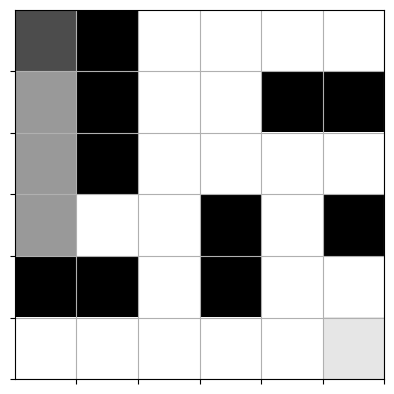

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


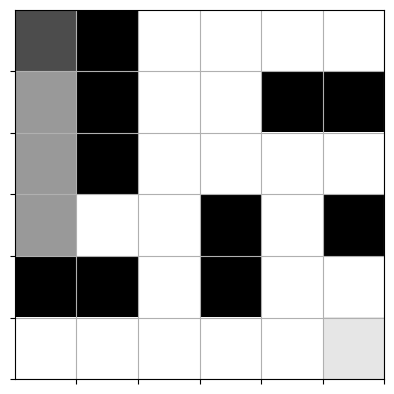

1/1 [==============================] - 0s 15ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 25ms/step


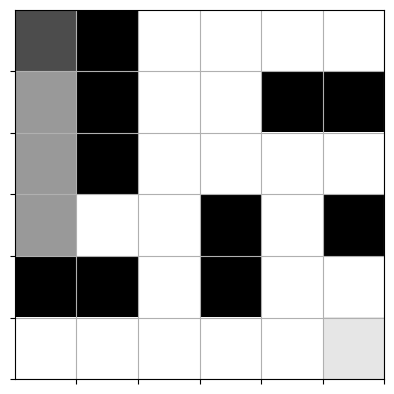

1/1 [==============================] - 0s 16ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 20ms/step


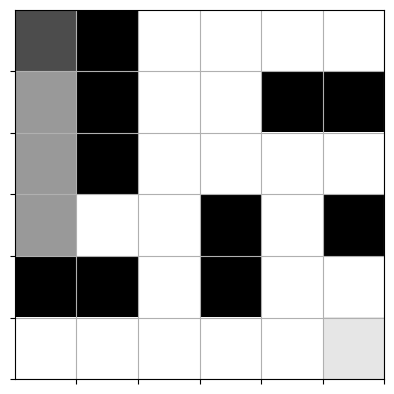

1/1 [==============================] - 0s 17ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


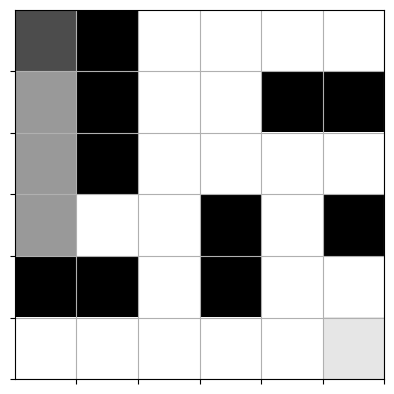

1/1 [==============================] - 0s 15ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


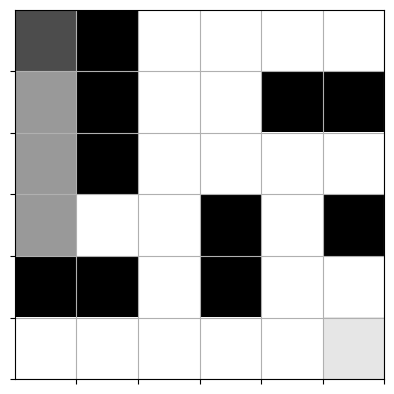

1/1 [==============================] - 0s 14ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


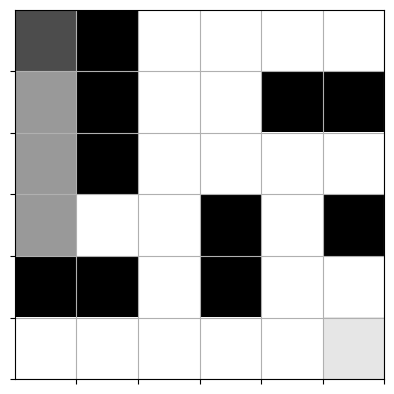

1/1 [==============================] - 0s 14ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 21ms/step


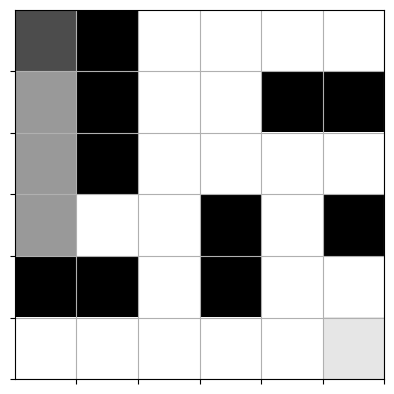

Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


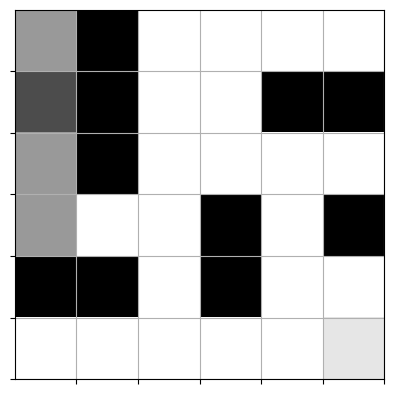

1/1 [==============================] - 0s 14ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


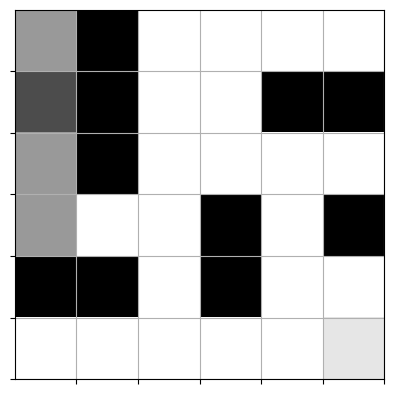

1/1 [==============================] - 0s 14ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


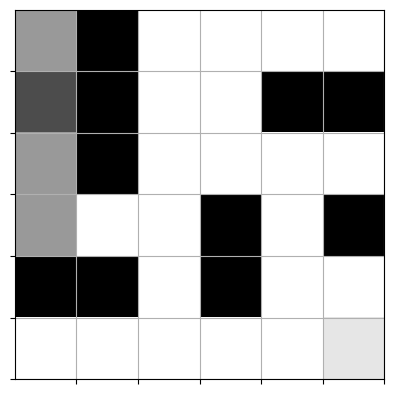

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


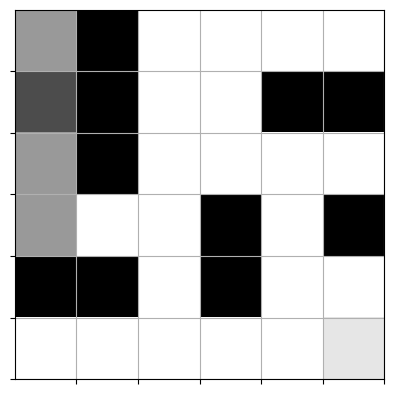

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 20ms/step


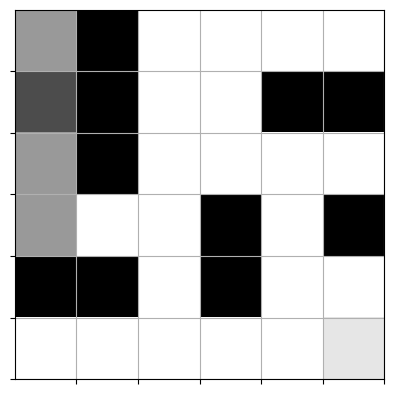

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


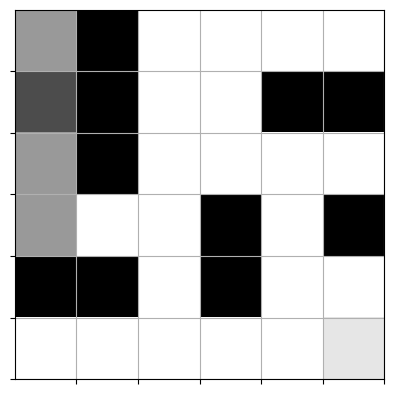

1/1 [==============================] - 0s 15ms/step
Action: left, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


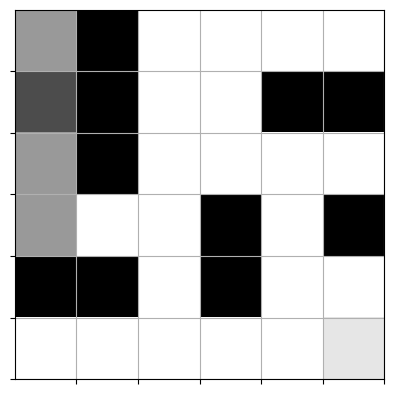

Epoch: 000/99 | Loss: 0.0050 | Episodes: 33 | Win count: 0 | Win rate: 0.000 | time: 55.5 seconds


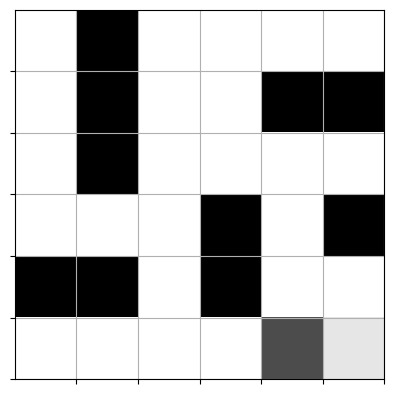

Action: right, Reward: 1.0
1/1 [==============================] - 0s 13ms/step


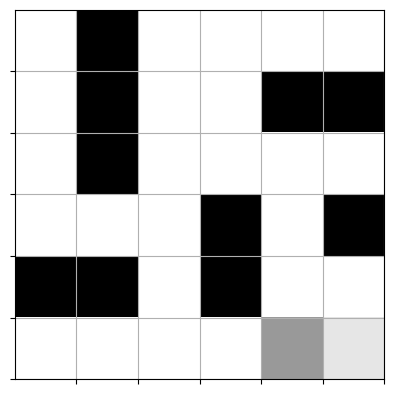

Epoch: 001/99 | Loss: 0.0170 | Episodes: 34 | Win count: 1 | Win rate: 0.000 | time: 58.4 seconds


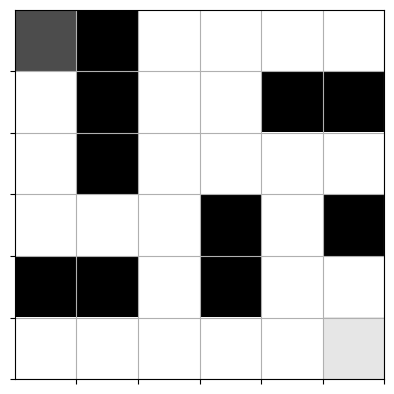

1/1 [==============================] - 0s 19ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


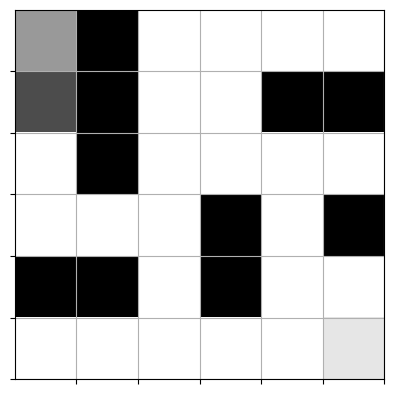

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


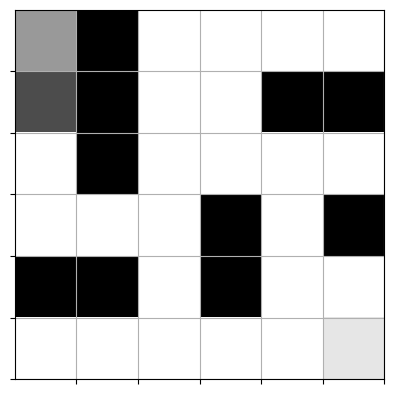

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


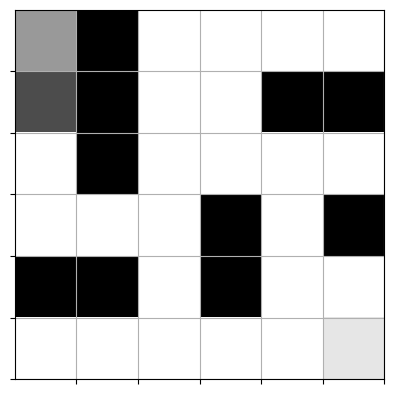

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


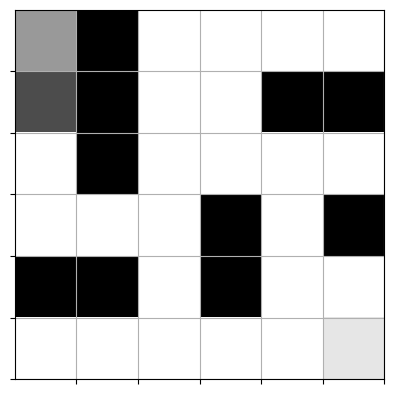

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


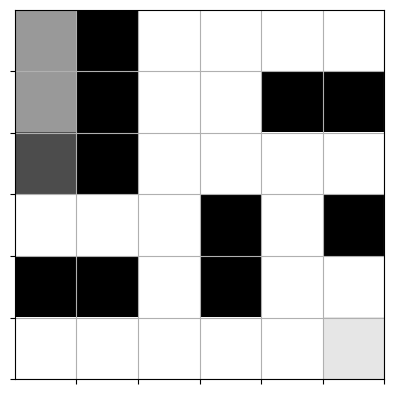

1/1 [==============================] - 0s 16ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


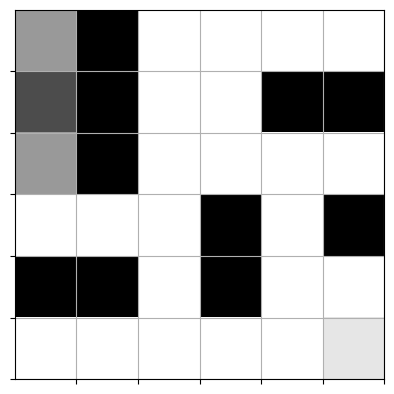

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


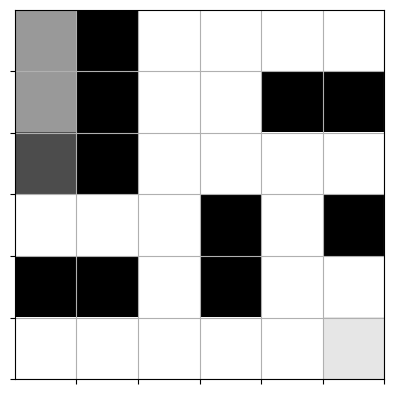

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 13ms/step


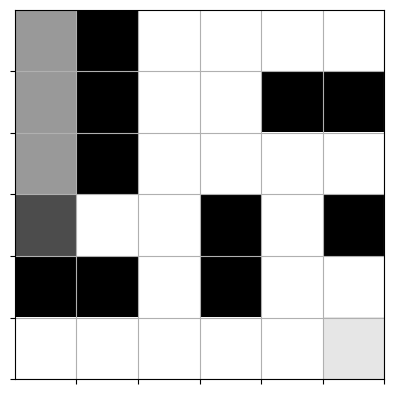

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


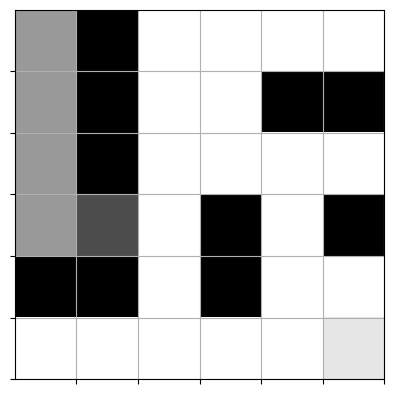

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


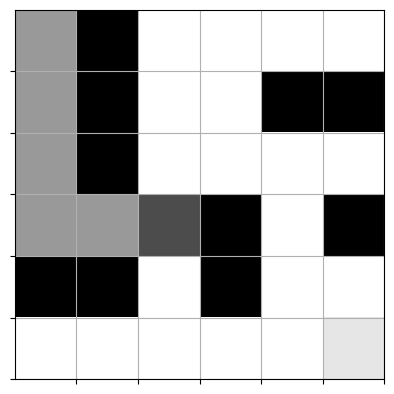

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


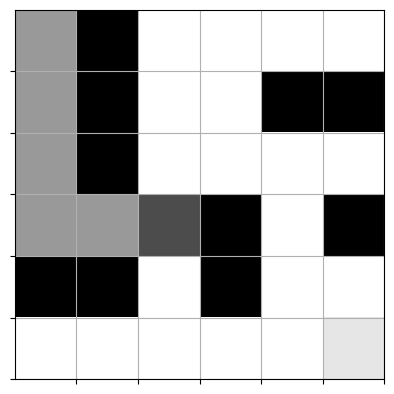

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


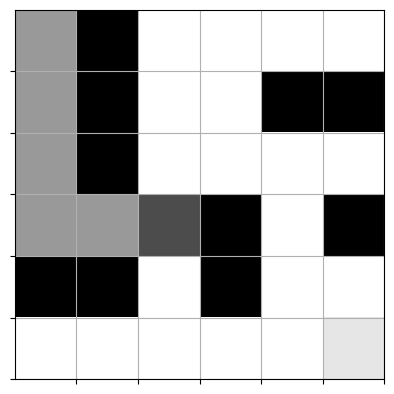

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


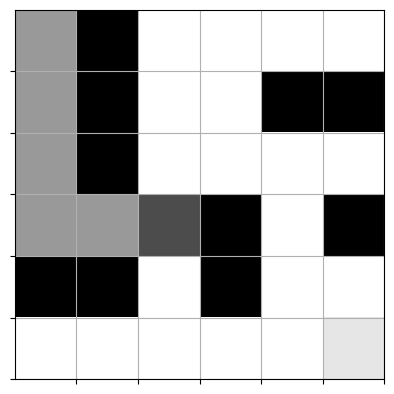

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


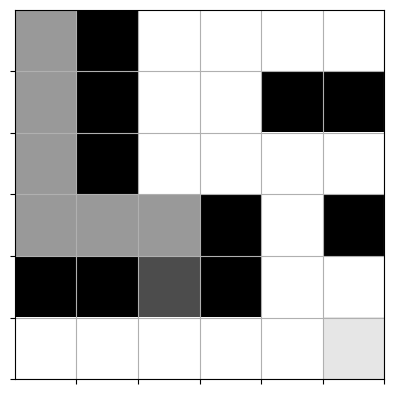

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


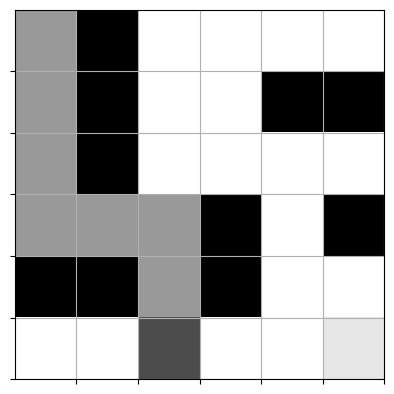

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


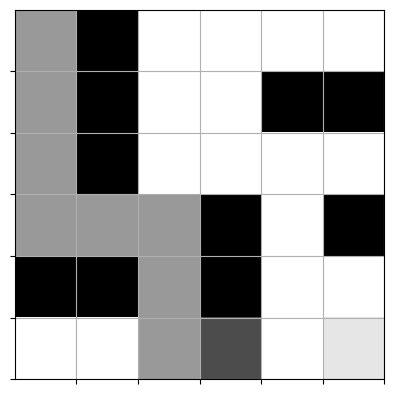

1/1 [==============================] - 0s 16ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


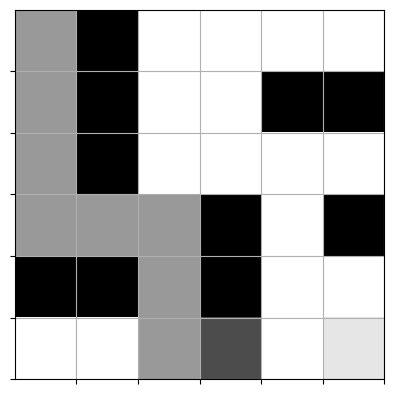

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


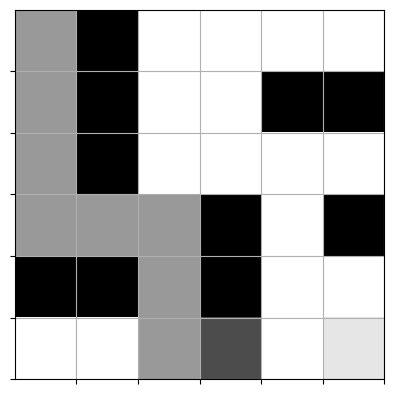

1/1 [==============================] - 0s 14ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


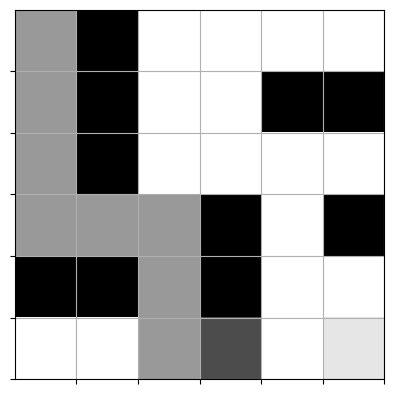

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


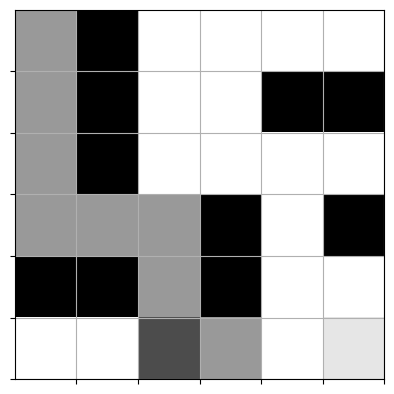

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


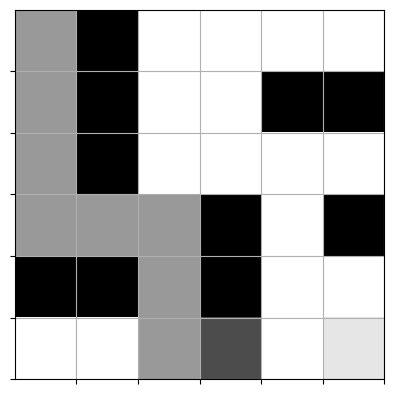

Action: left, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


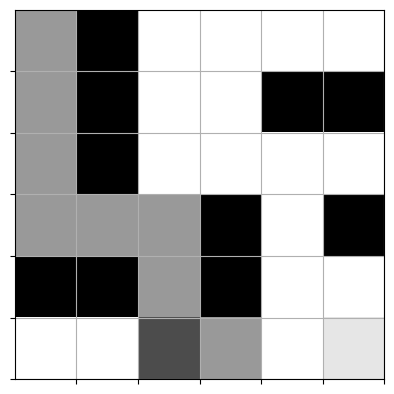

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


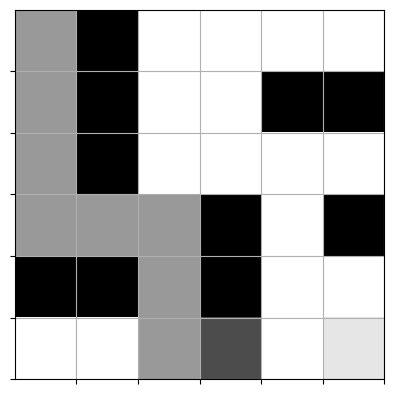

Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


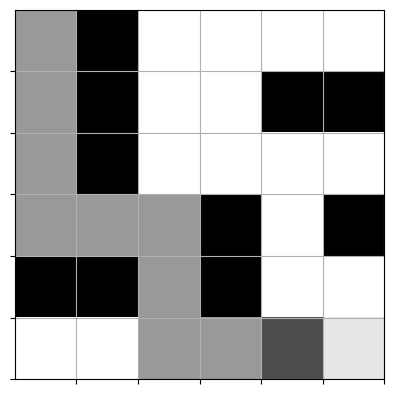

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 13ms/step


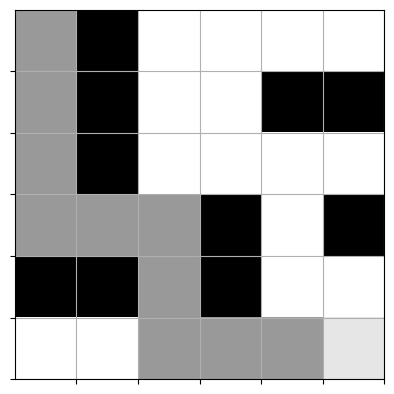

Epoch: 002/99 | Loss: 0.0045 | Episodes: 59 | Win count: 2 | Win rate: 0.000 | time: 132.2 seconds


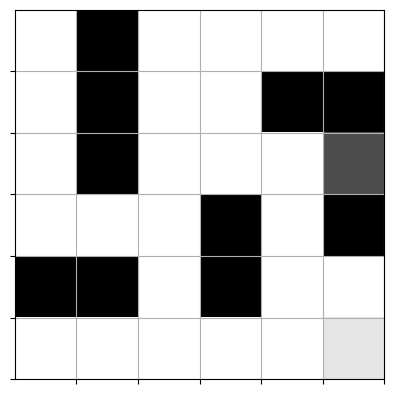

1/1 [==============================] - 0s 16ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


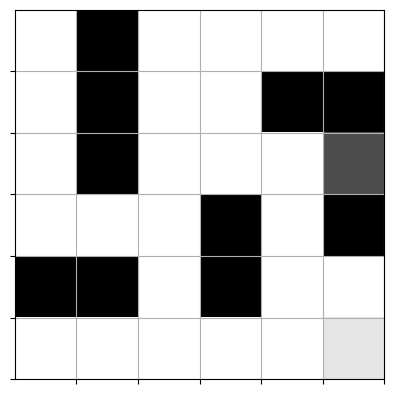

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


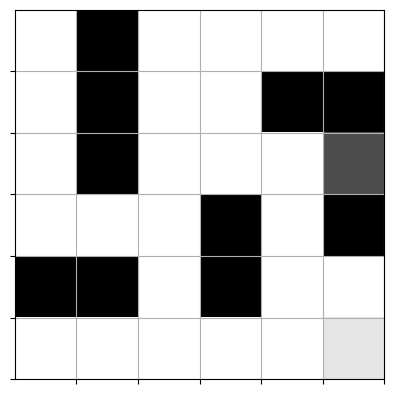

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


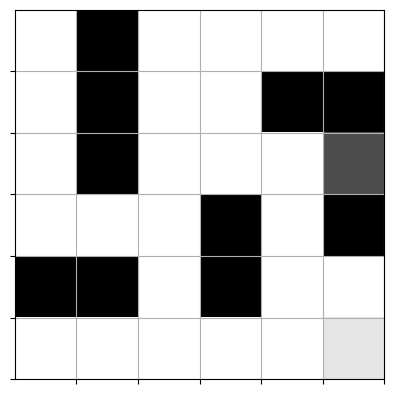

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


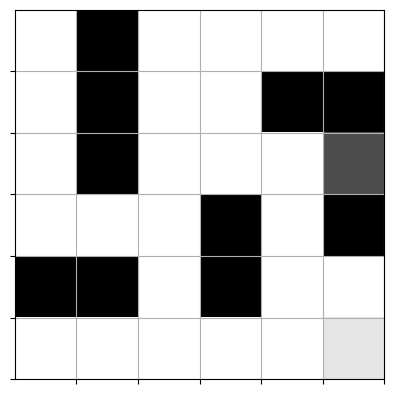

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


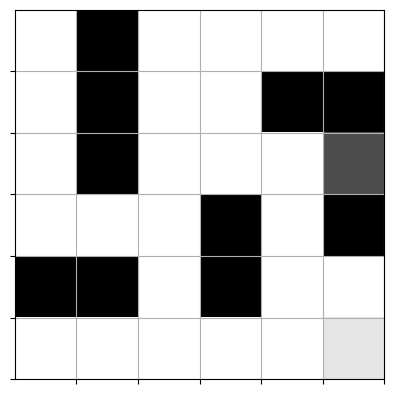

Action: left, Reward: 0.04
1/1 [==============================] - 0s 20ms/step


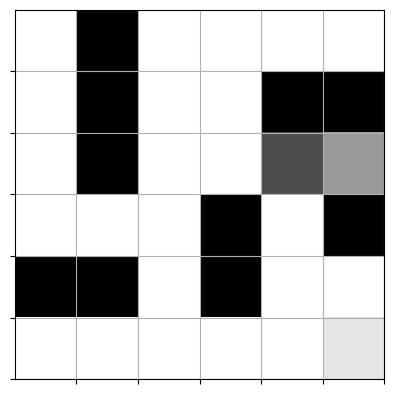

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


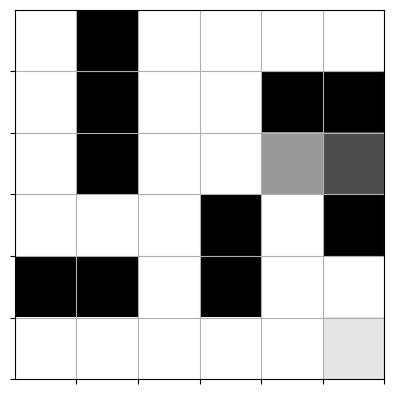

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


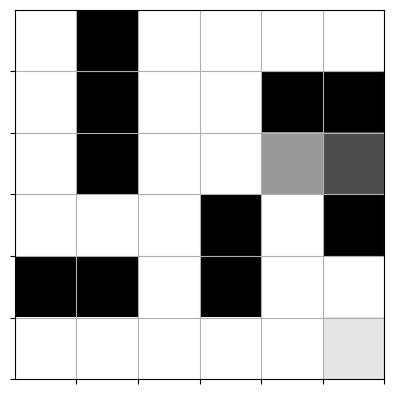

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


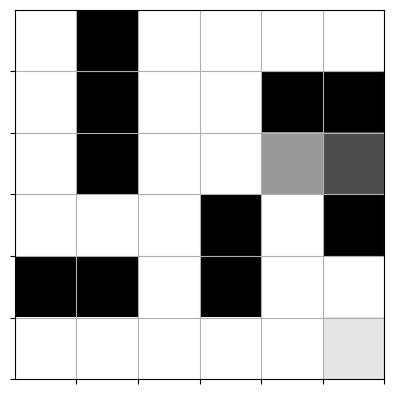

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


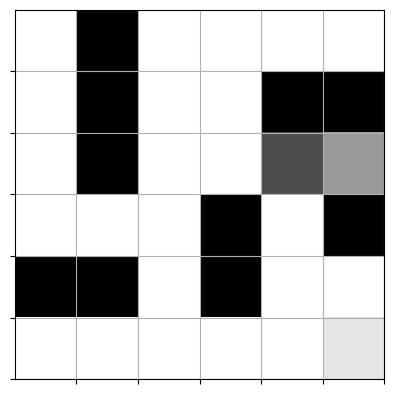

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


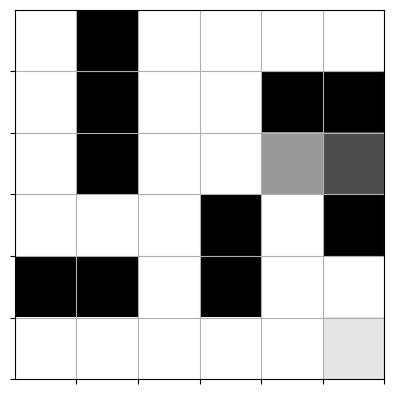

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


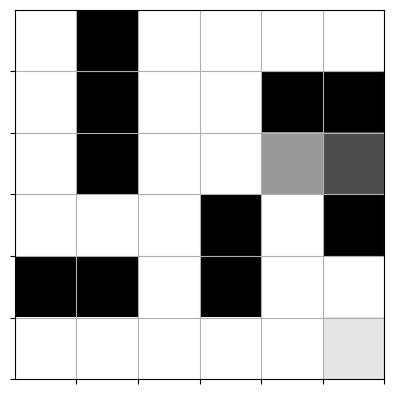

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


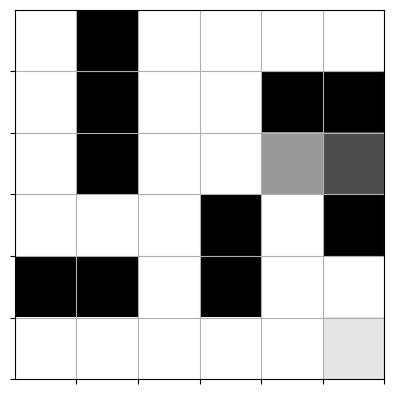

1/1 [==============================] - 0s 14ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


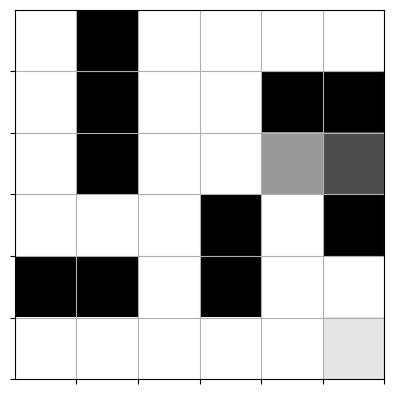

1/1 [==============================] - 0s 14ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


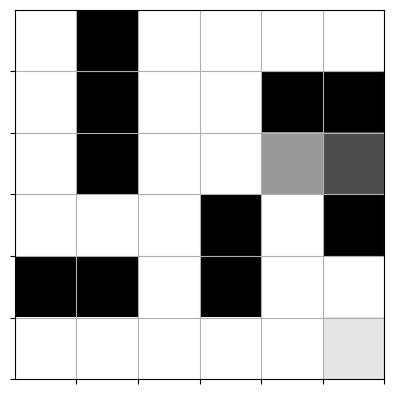

Action: left, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


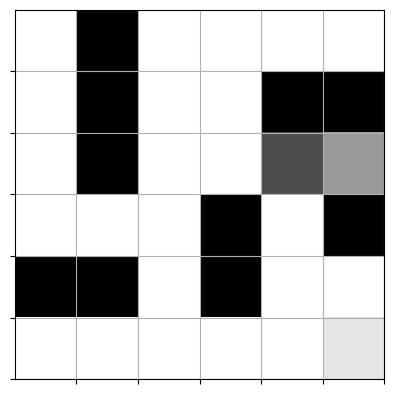

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


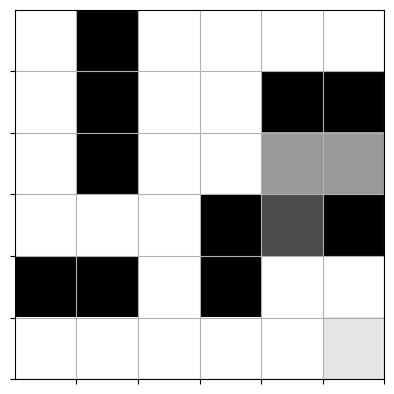

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


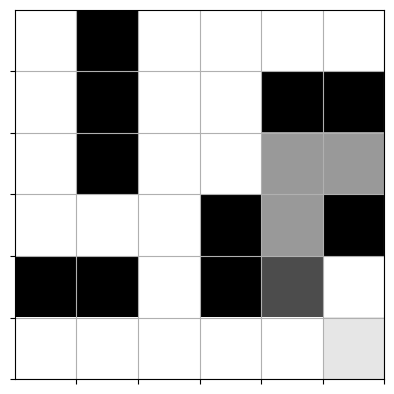

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


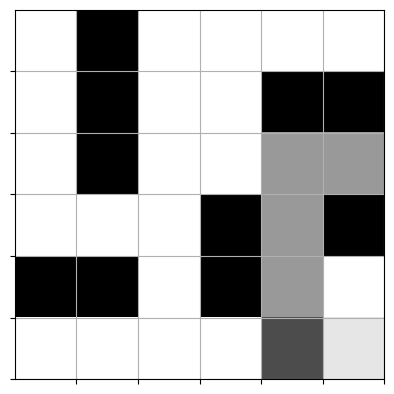

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


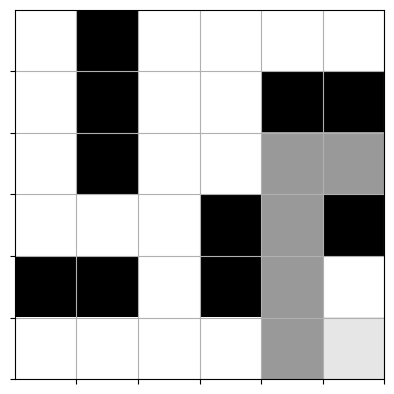

Epoch: 003/99 | Loss: 0.0070 | Episodes: 79 | Win count: 3 | Win rate: 0.000 | time: 191.1 seconds


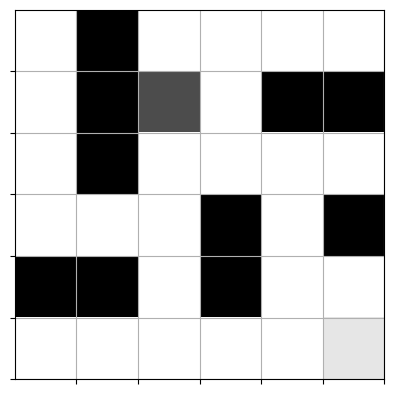

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


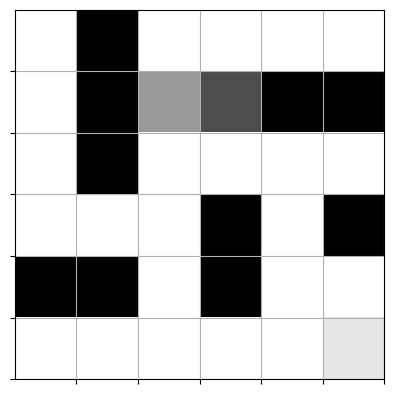

1/1 [==============================] - 0s 20ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


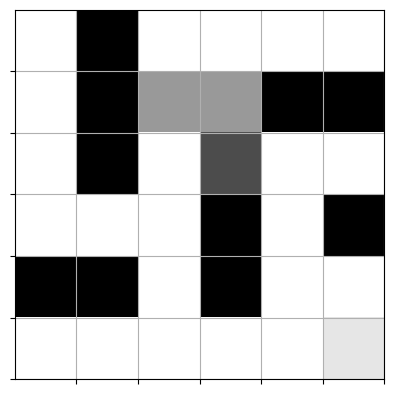

1/1 [==============================] - 0s 19ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


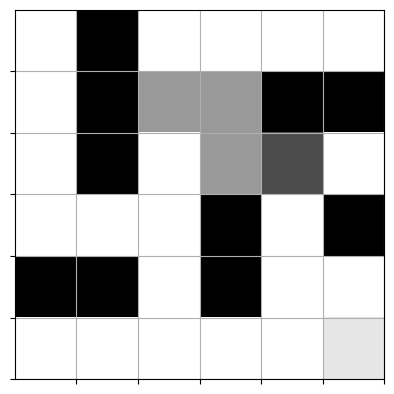

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


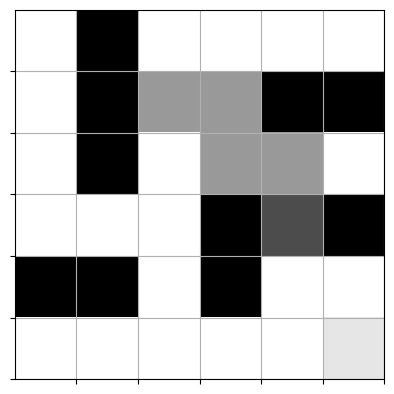

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


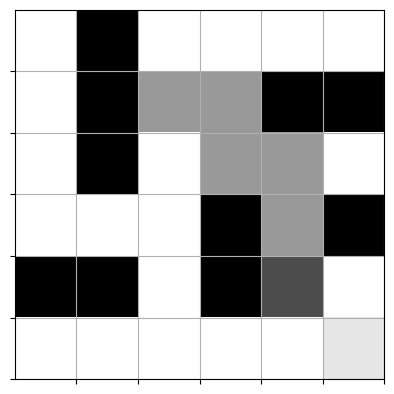

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


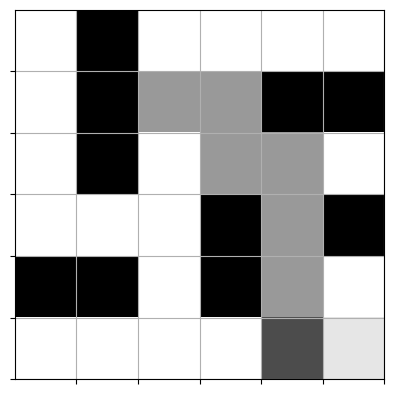

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 13ms/step


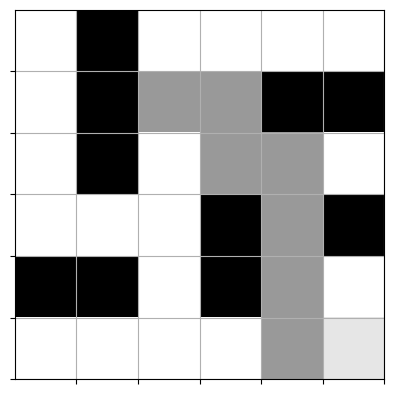

Epoch: 004/99 | Loss: 0.0063 | Episodes: 86 | Win count: 4 | Win rate: 0.000 | time: 212.8 seconds


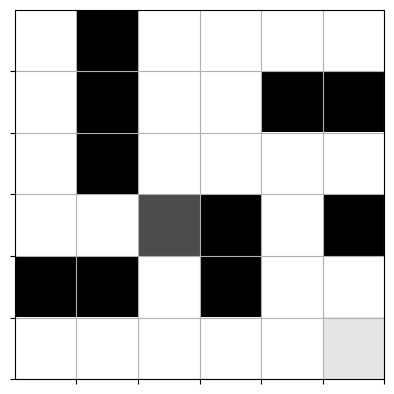

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


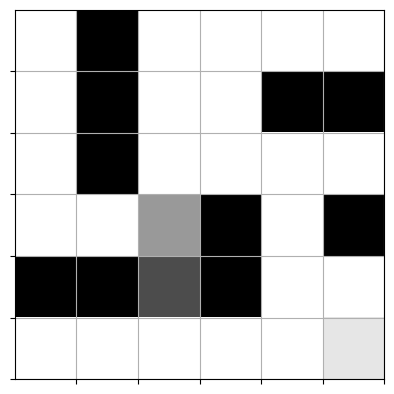

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 21ms/step


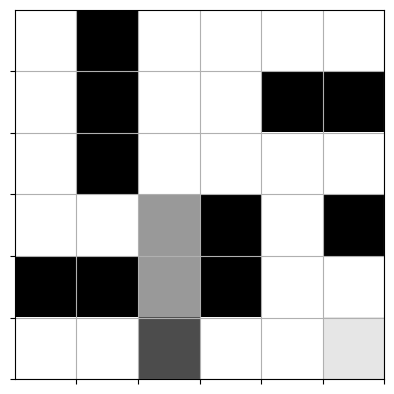

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 13ms/step


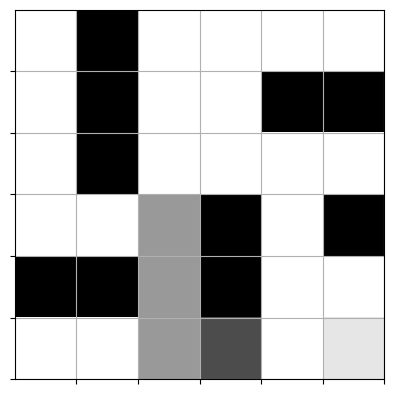

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


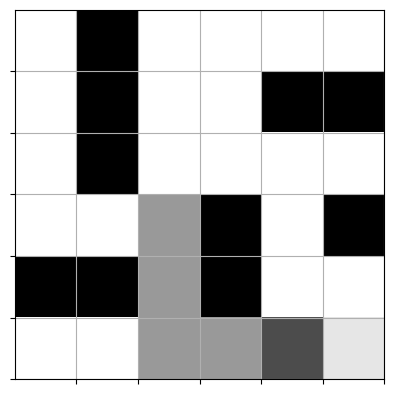

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 17ms/step


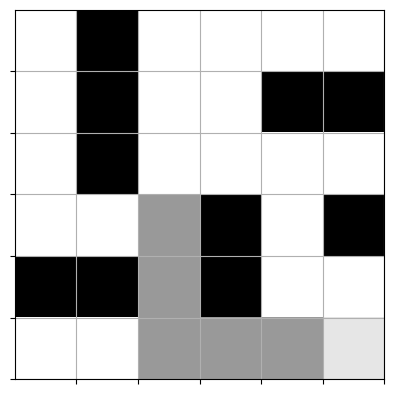

Epoch: 005/99 | Loss: 0.0072 | Episodes: 91 | Win count: 5 | Win rate: 0.000 | time: 228.1 seconds


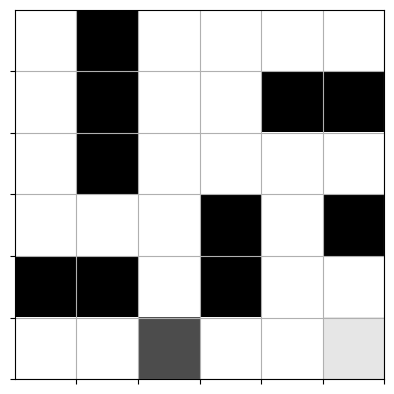

Action: left, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


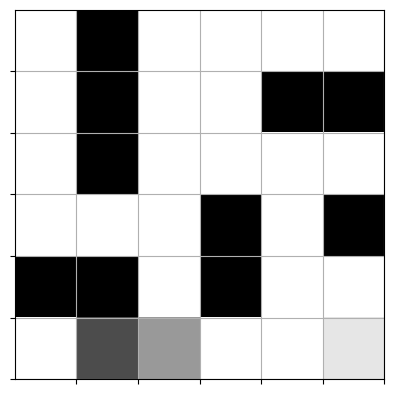

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


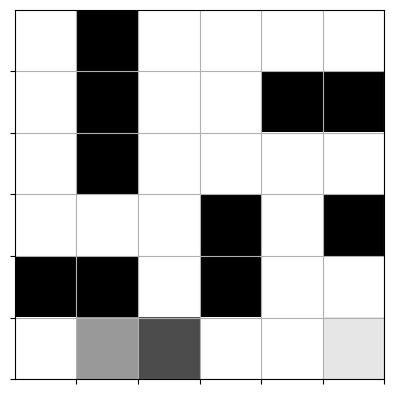

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


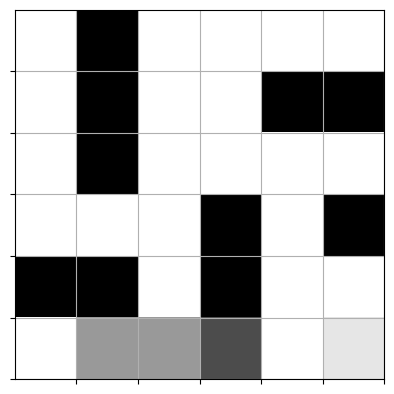

Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


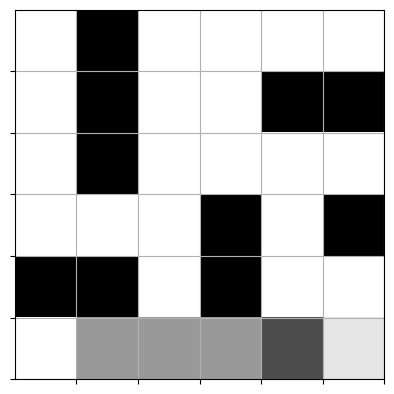

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 14ms/step


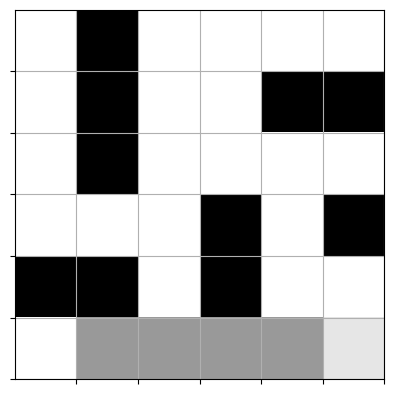

Epoch: 006/99 | Loss: 0.0083 | Episodes: 96 | Win count: 6 | Win rate: 0.000 | time: 243.0 seconds


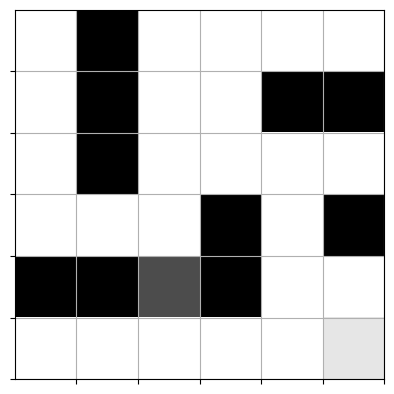

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


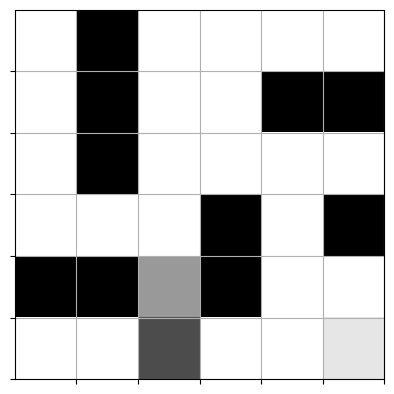

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


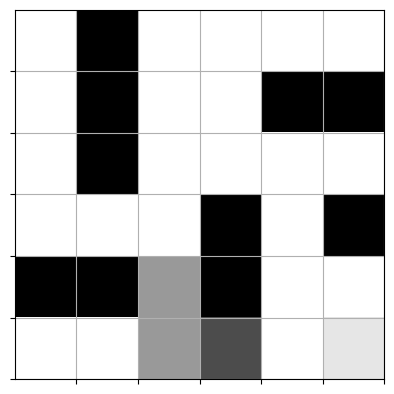

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


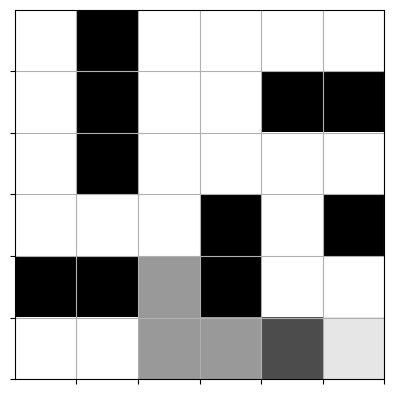

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 14ms/step


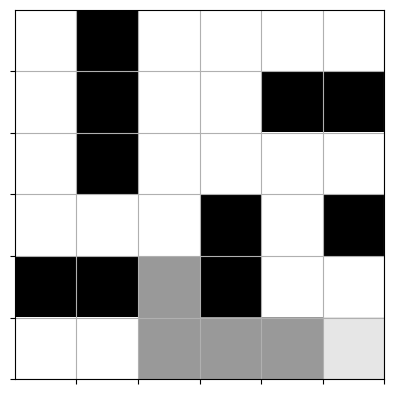

Epoch: 007/99 | Loss: 0.0081 | Episodes: 100 | Win count: 7 | Win rate: 0.000 | time: 254.8 seconds


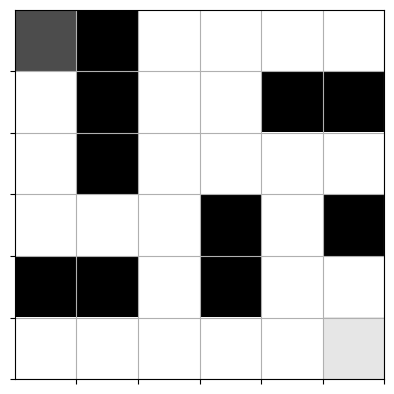

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


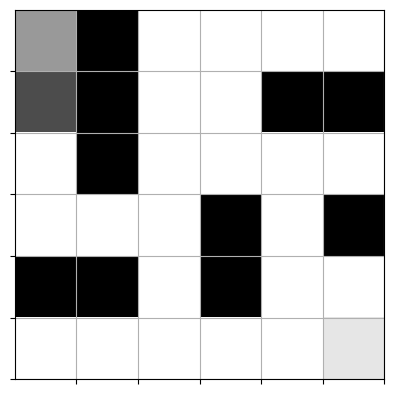

Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


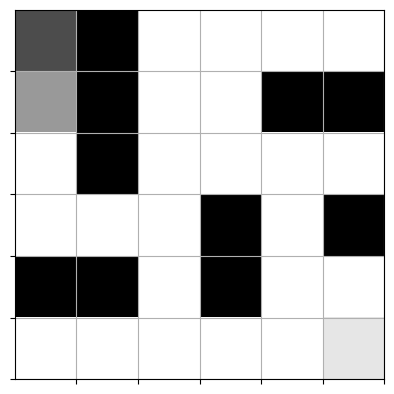

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


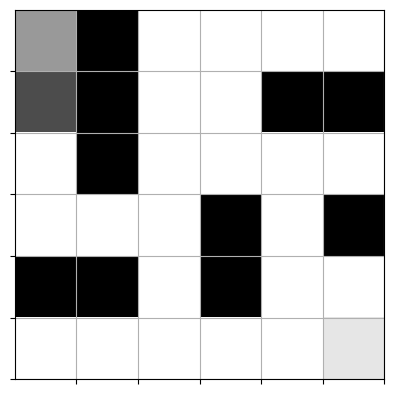

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


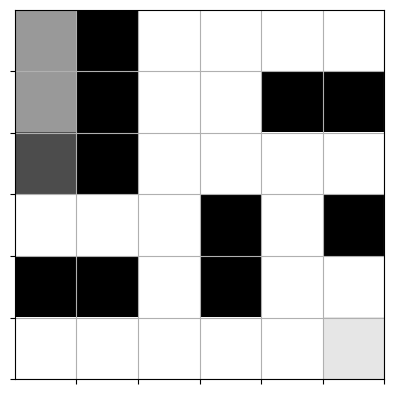

Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


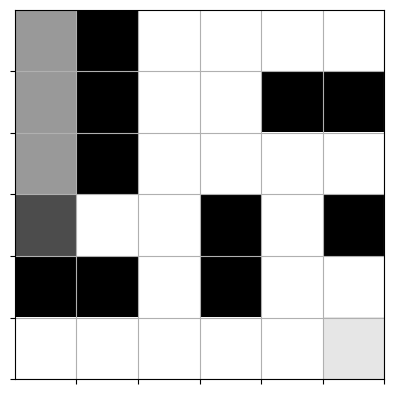

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


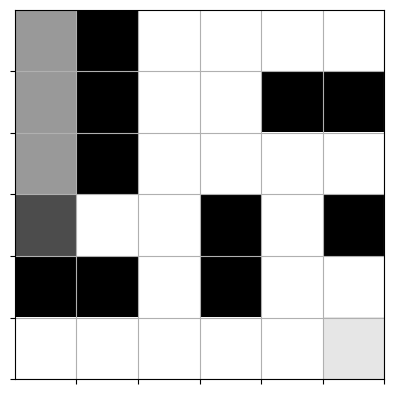

Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


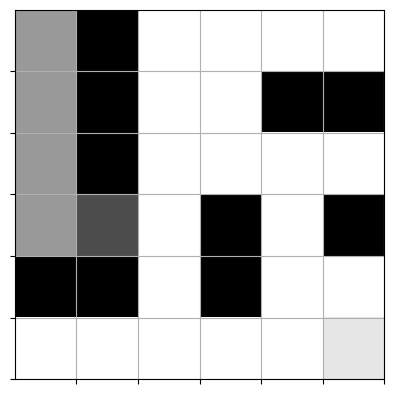

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


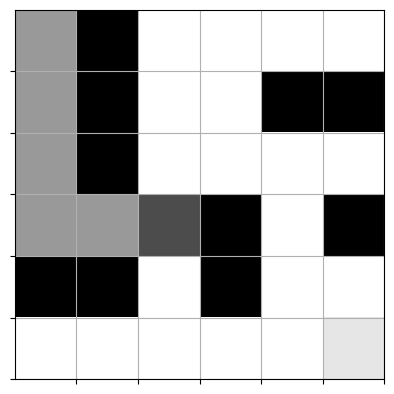

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


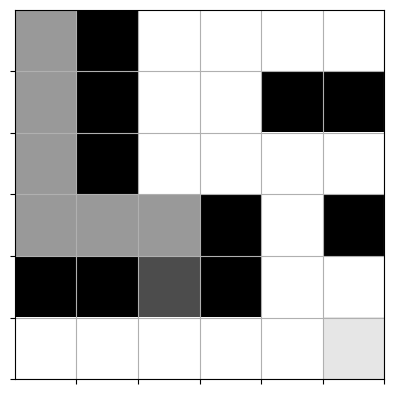

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


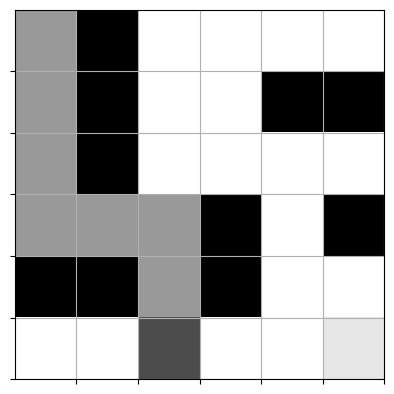

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


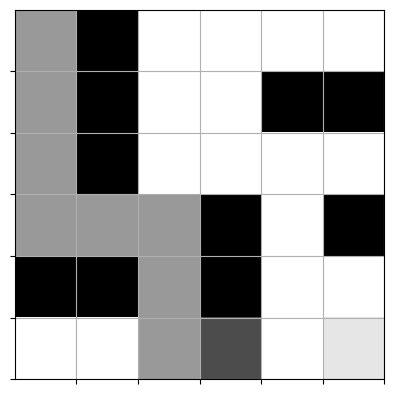

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


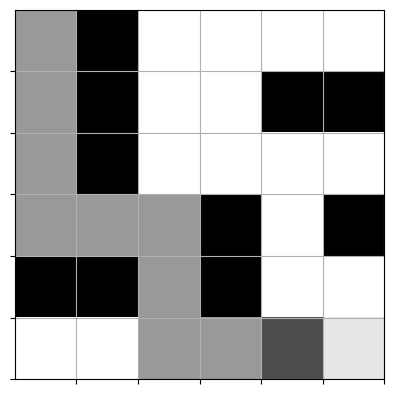

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 14ms/step


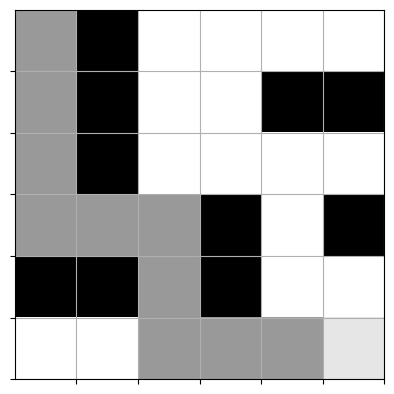

Epoch: 008/99 | Loss: 0.0039 | Episodes: 113 | Win count: 8 | Win rate: 0.000 | time: 294.5 seconds


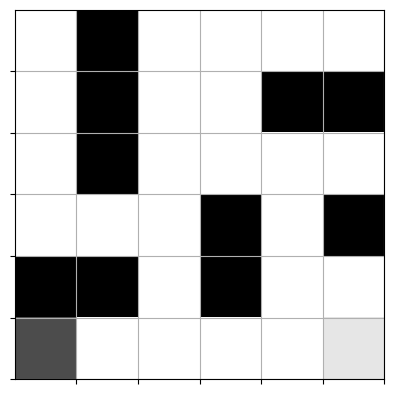

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


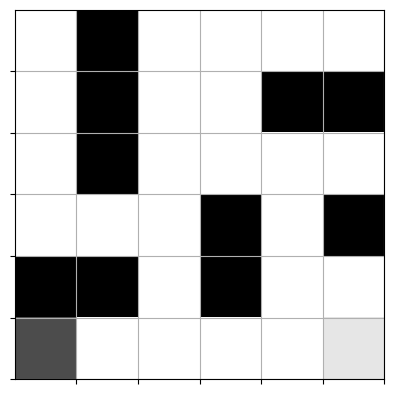

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


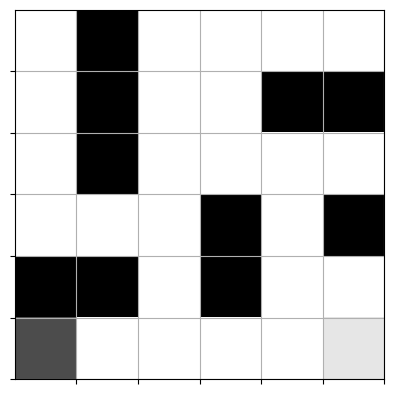

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


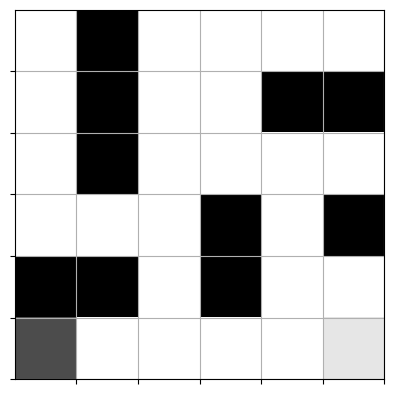

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


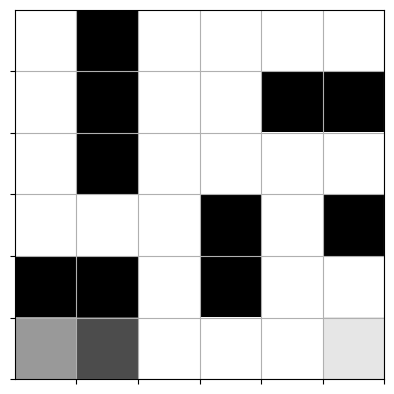

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


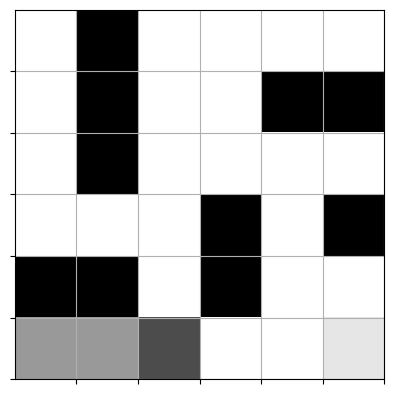

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


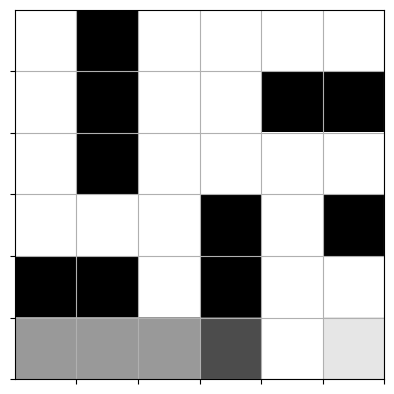

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


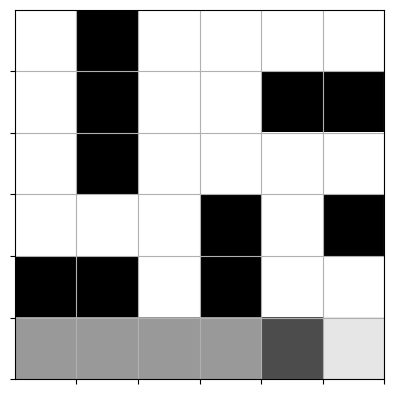

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 15ms/step


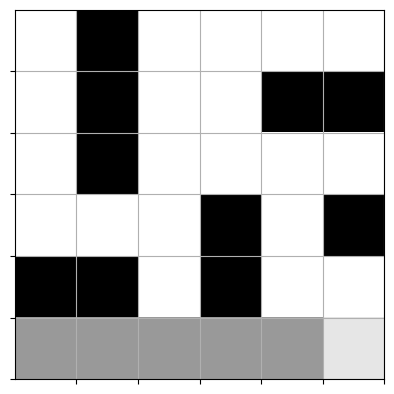

Epoch: 009/99 | Loss: 0.0019 | Episodes: 121 | Win count: 9 | Win rate: 0.000 | time: 318.0 seconds


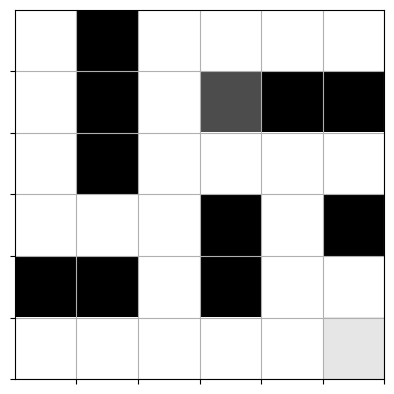

Action: left, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


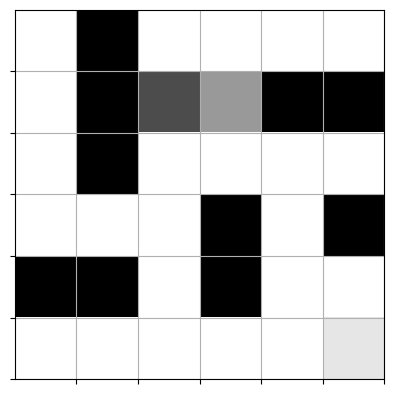

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


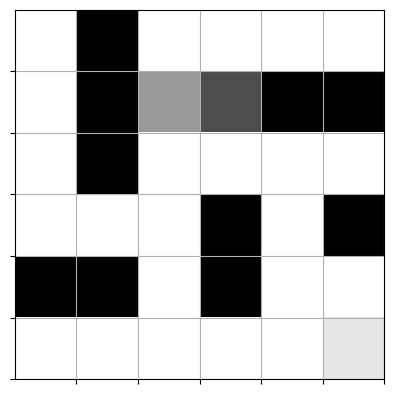

Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


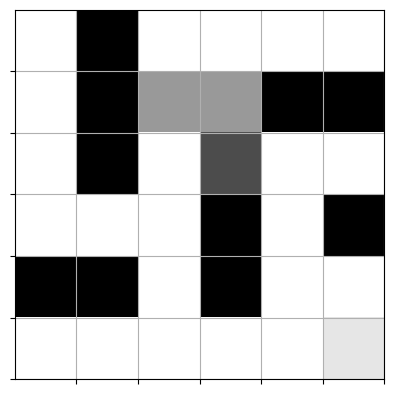

Action: up, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


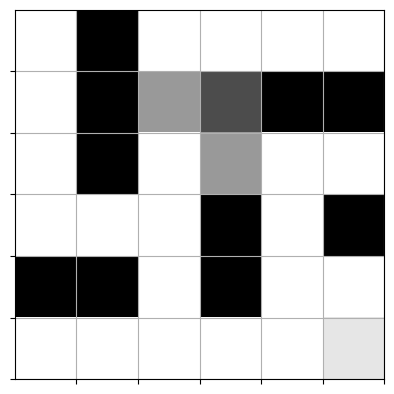

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


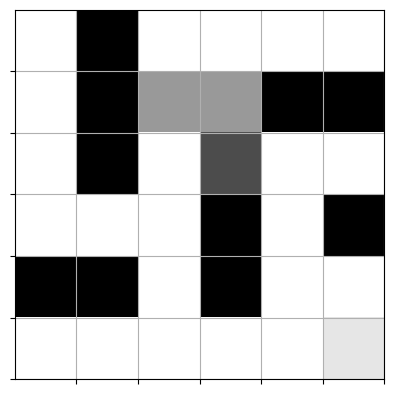

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


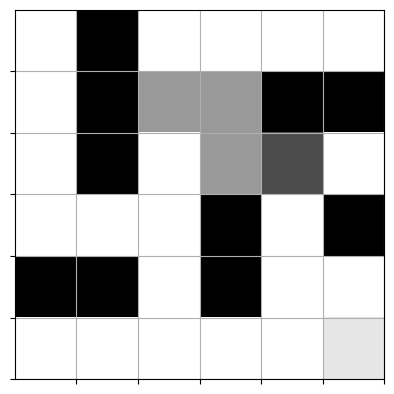

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


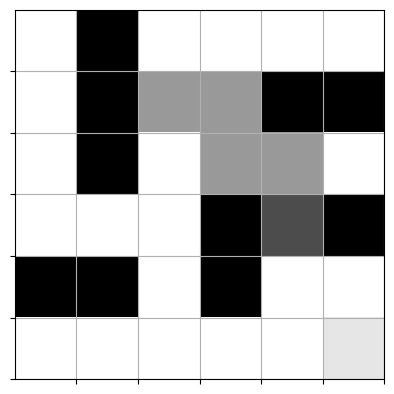

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


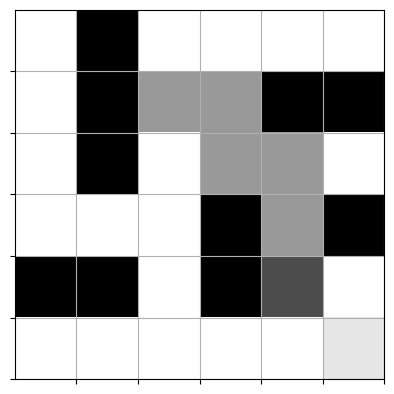

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


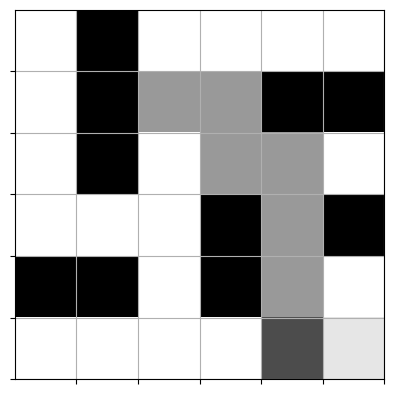

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 15ms/step


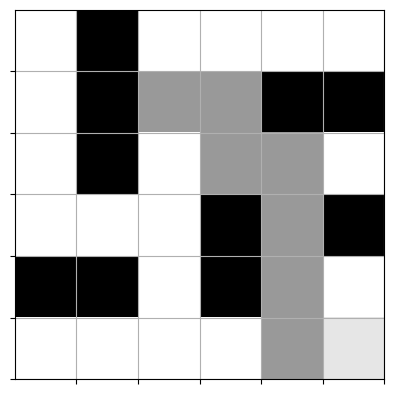

Epoch: 010/99 | Loss: 0.0030 | Episodes: 131 | Win count: 10 | Win rate: 0.000 | time: 347.5 seconds


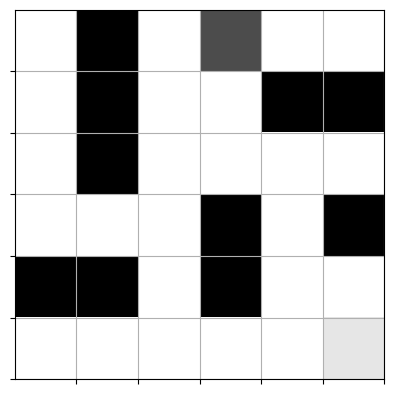

Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


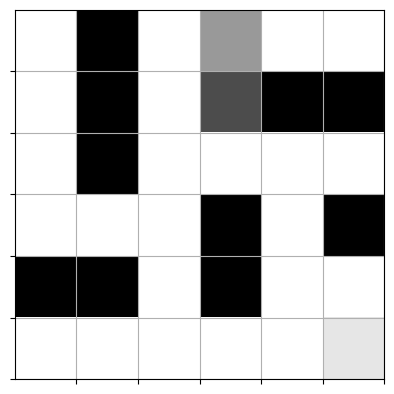

Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


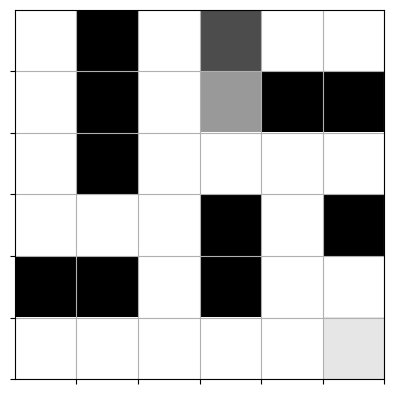

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


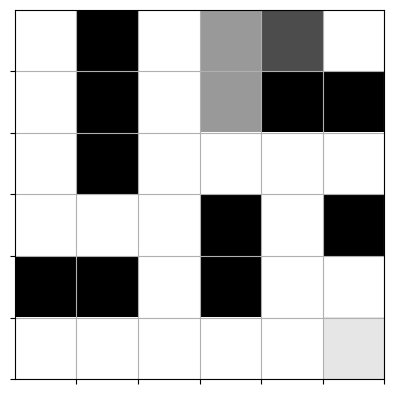

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


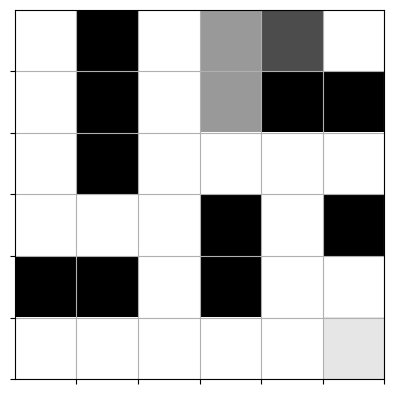

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


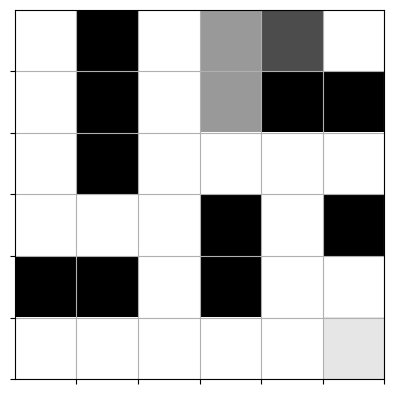

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


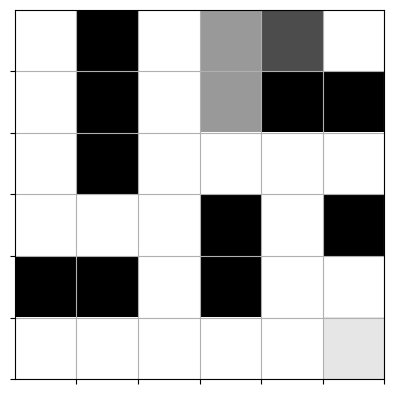

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


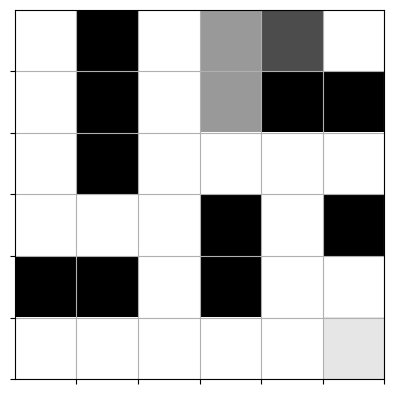

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


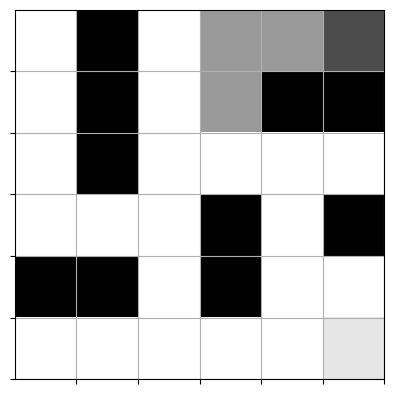

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


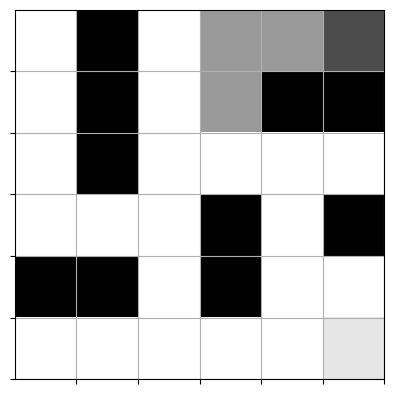

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


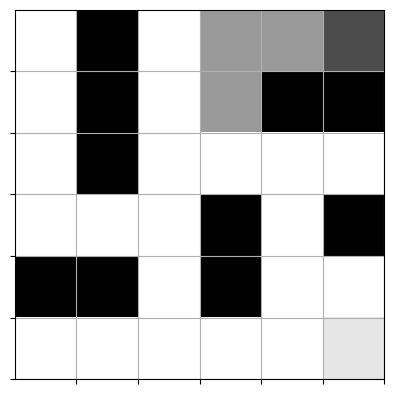

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


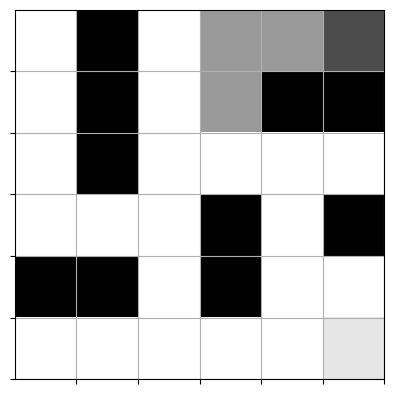

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


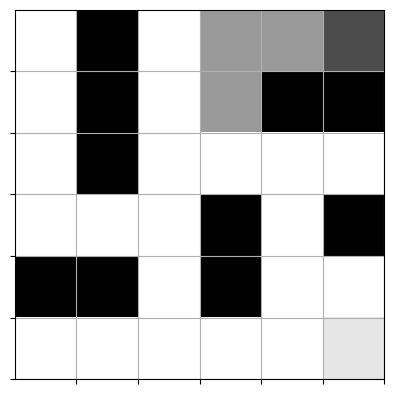

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


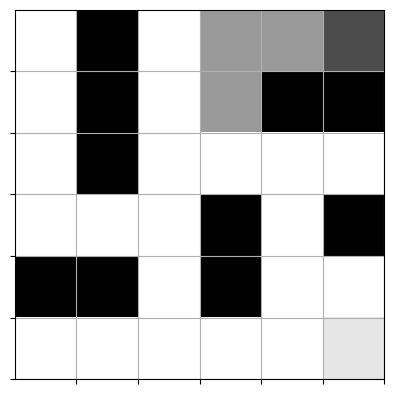

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


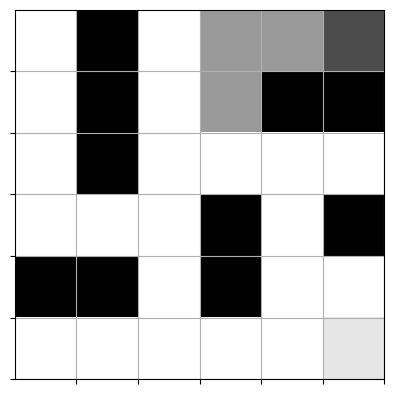

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


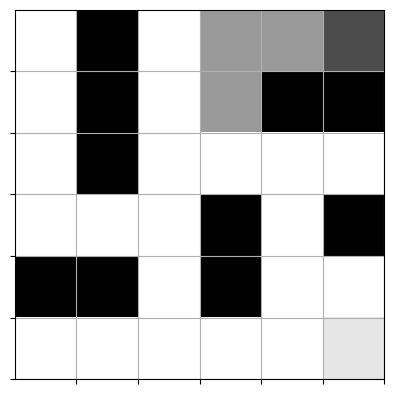

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


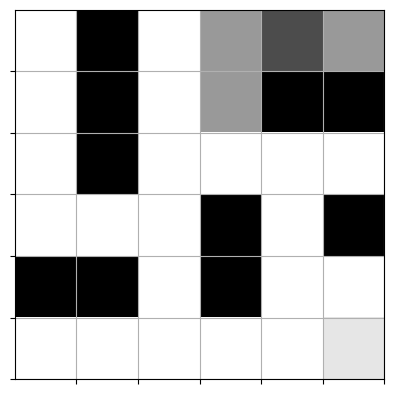

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


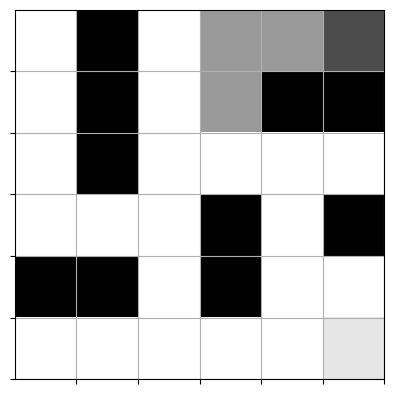

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


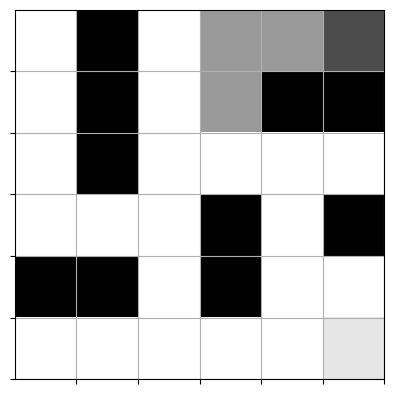

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


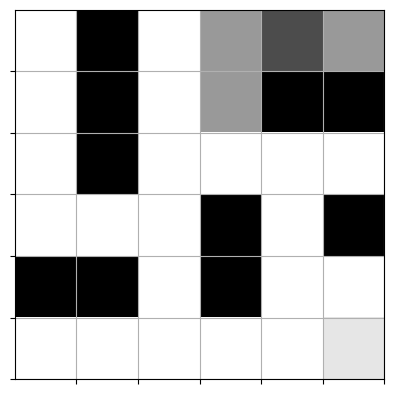

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 18ms/step


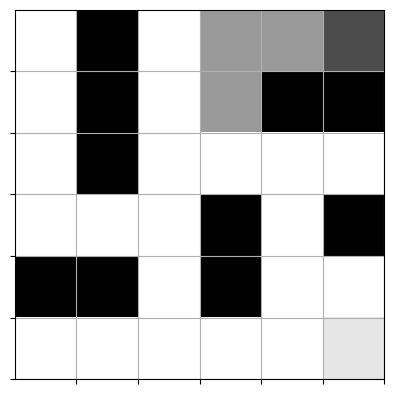

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


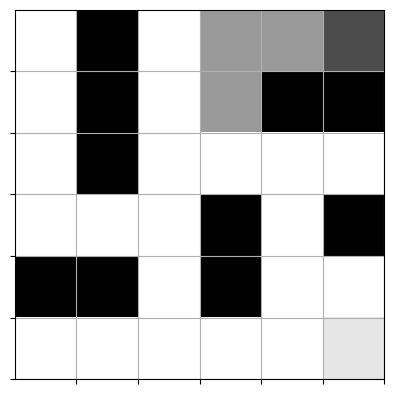

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


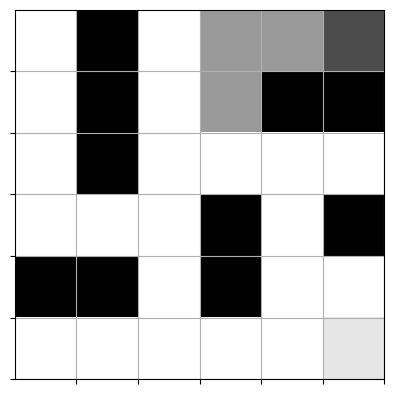

1/1 [==============================] - 0s 13ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


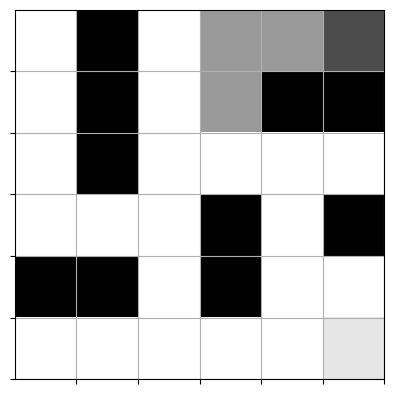

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


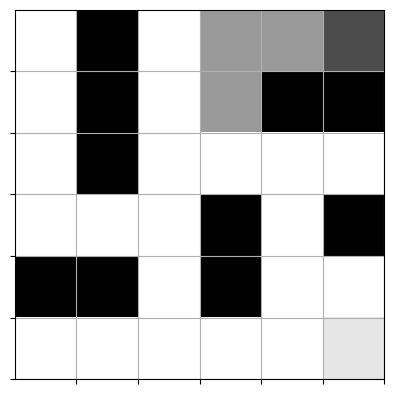

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


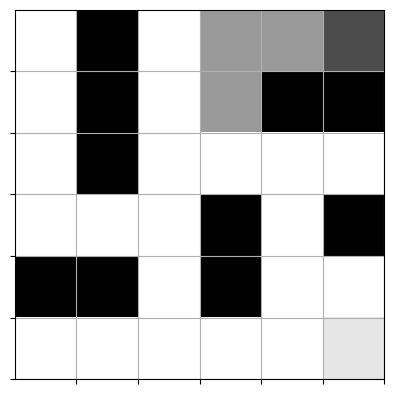

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


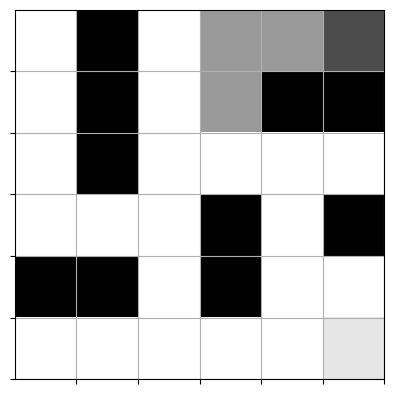

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


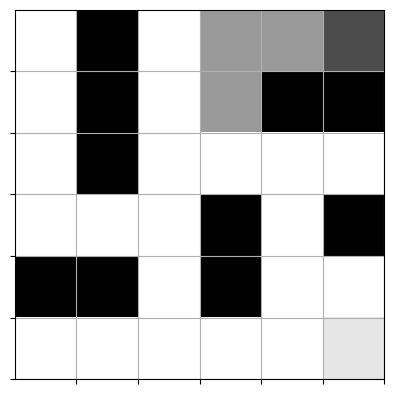

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


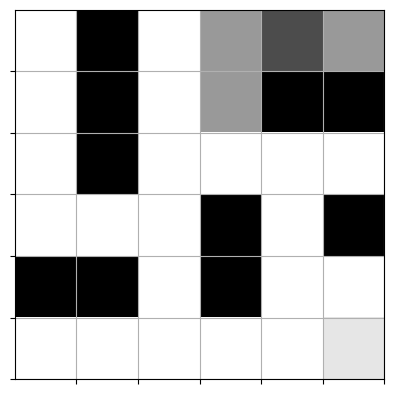

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


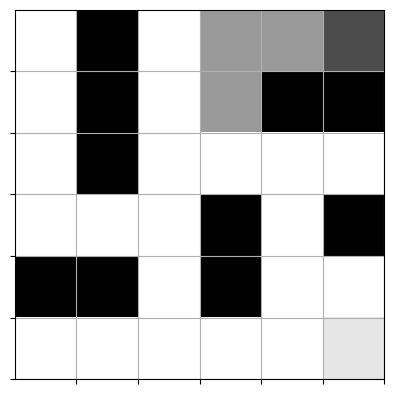

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


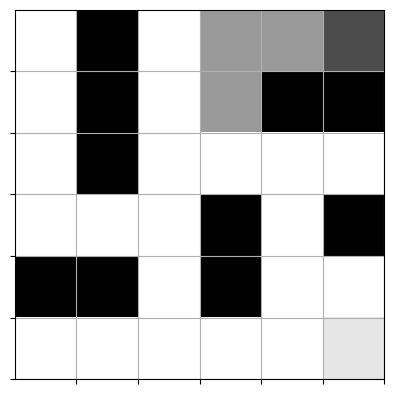

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 13ms/step


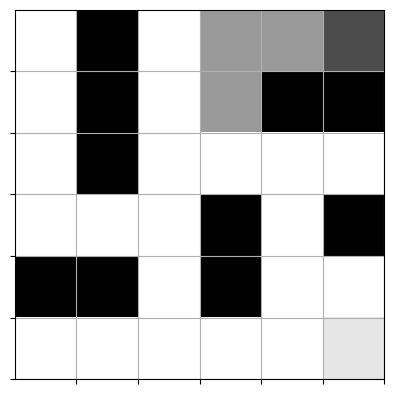

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


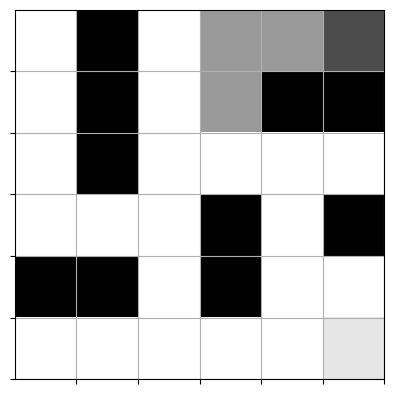

1/1 [==============================] - 0s 15ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


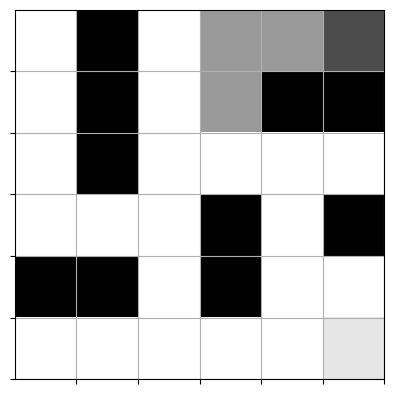

Epoch: 011/99 | Loss: 0.0040 | Episodes: 164 | Win count: 10 | Win rate: 0.000 | time: 7.41 minutes


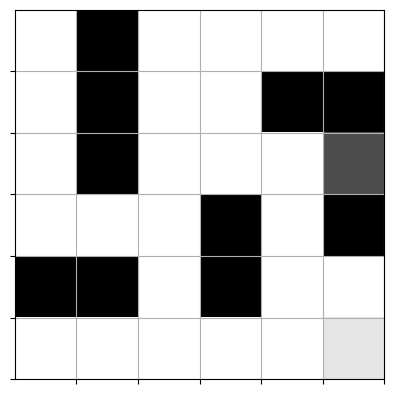

Action: left, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


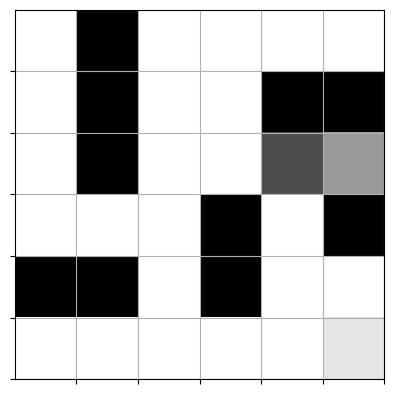

Action: left, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


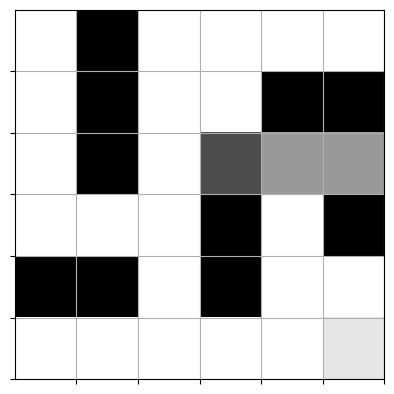

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


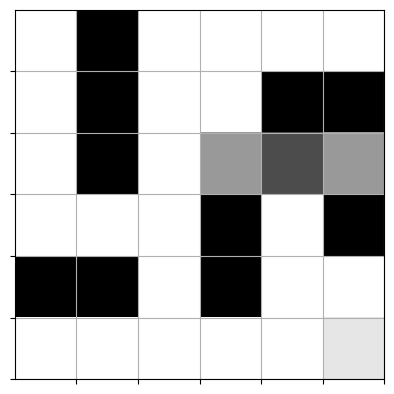

Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


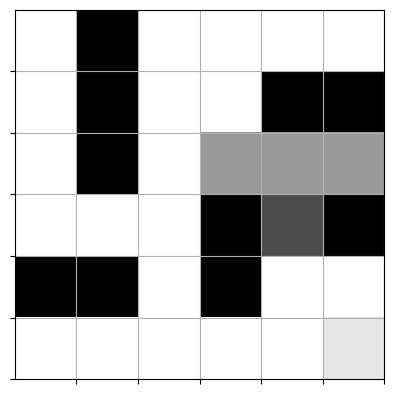

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


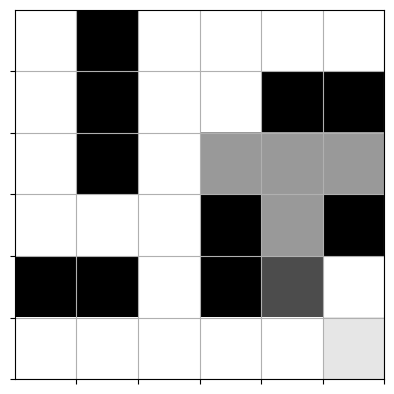

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


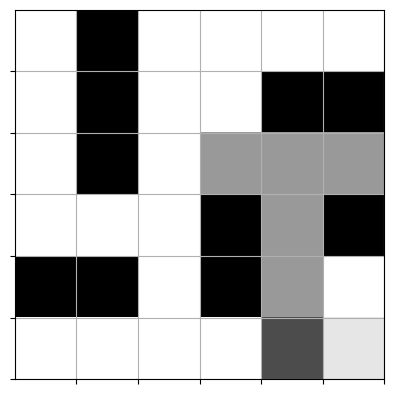

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 14ms/step


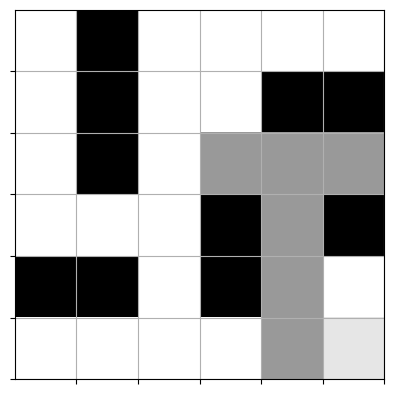

Epoch: 012/99 | Loss: 0.0038 | Episodes: 171 | Win count: 11 | Win rate: 0.000 | time: 7.76 minutes


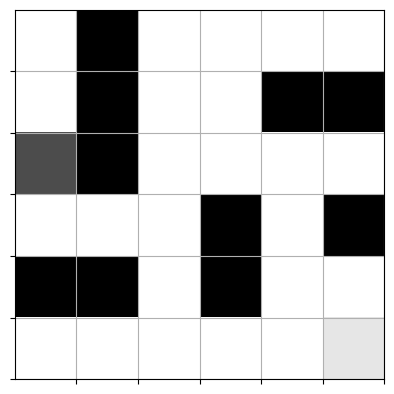

Action: up, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


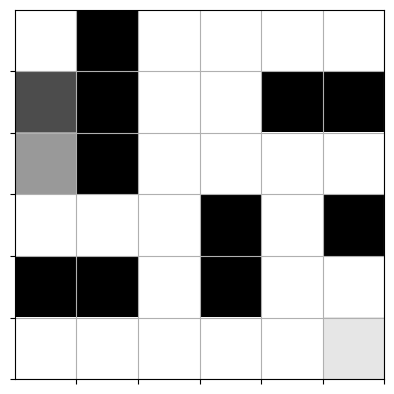

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


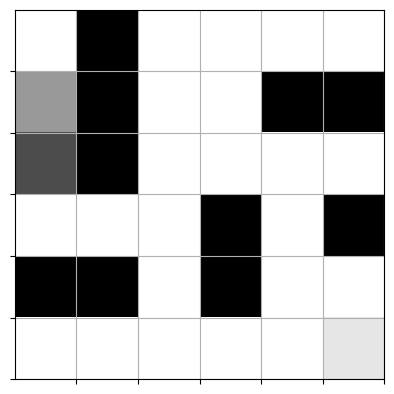

1/1 [==============================] - 0s 21ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


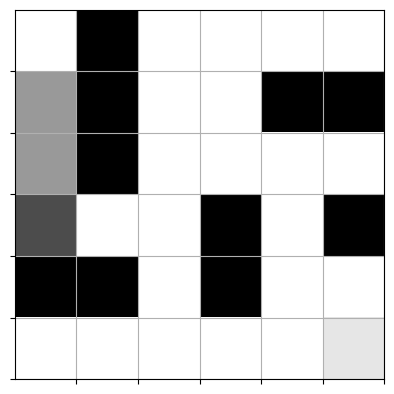

1/1 [==============================] - 0s 15ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


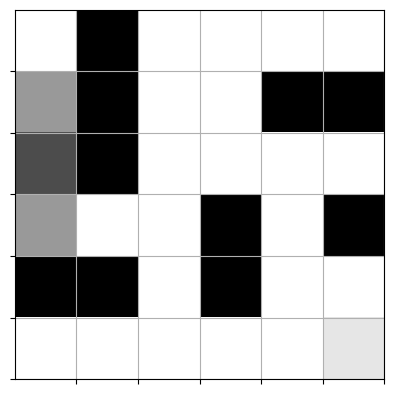

Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


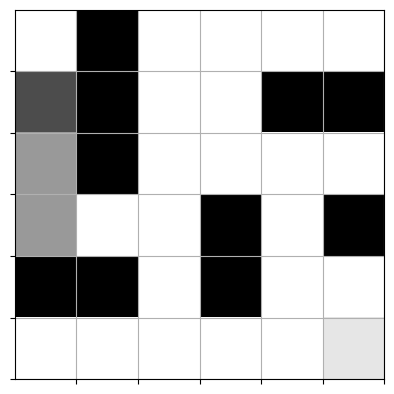

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 18ms/step


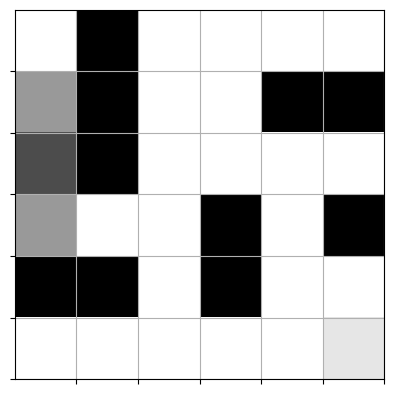

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


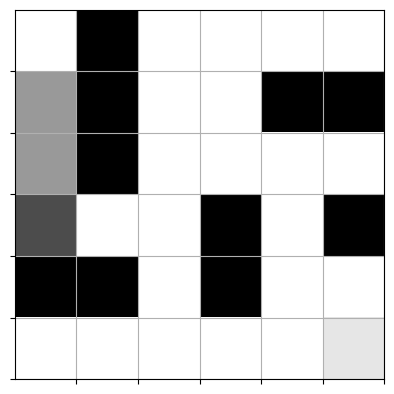

1/1 [==============================] - 0s 15ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


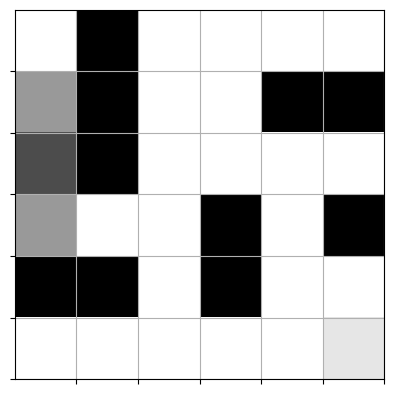

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


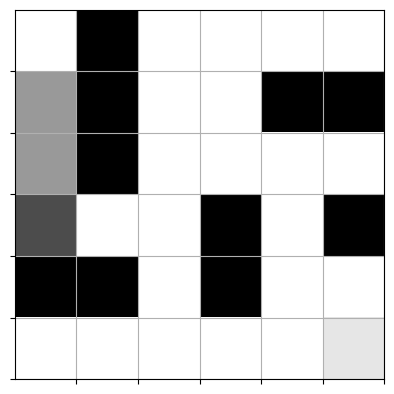

1/1 [==============================] - 0s 15ms/step
Action: up, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


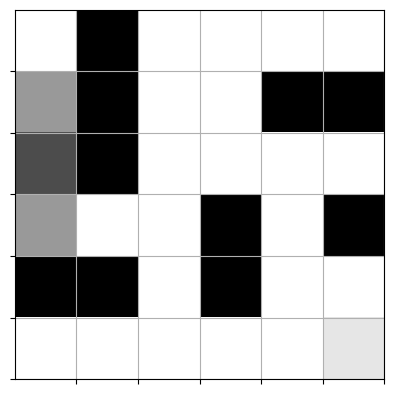

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


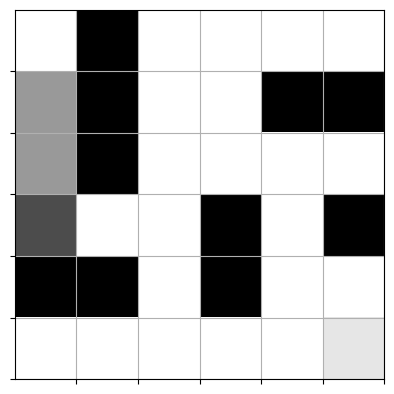

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


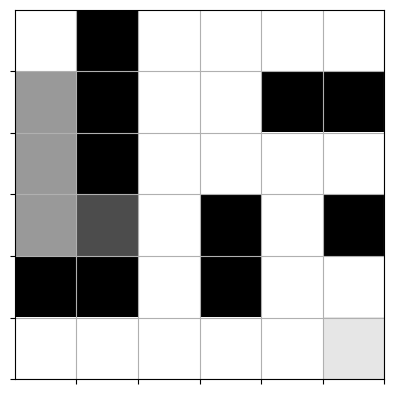

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


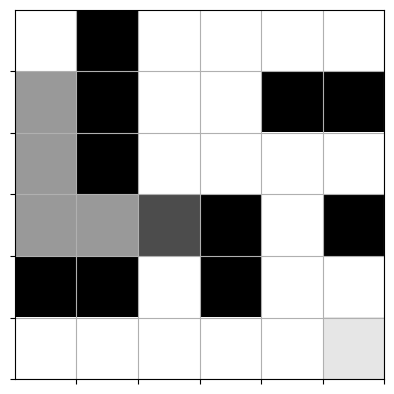

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


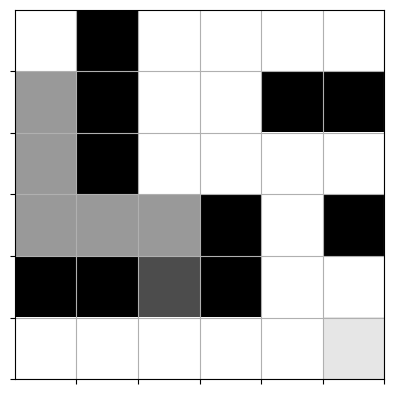

Action: up, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


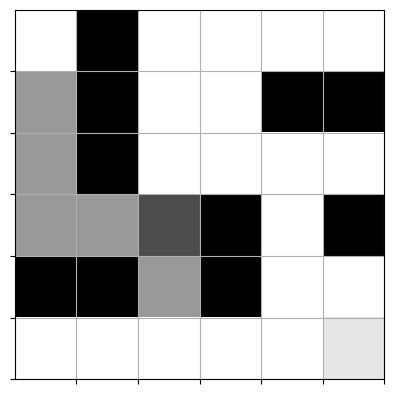

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


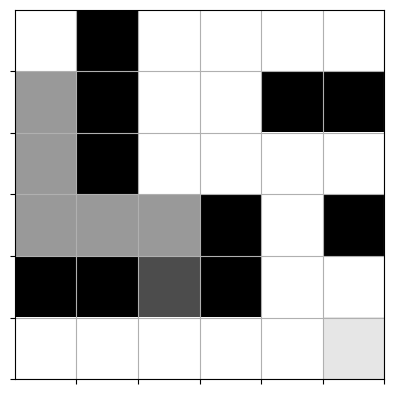

1/1 [==============================] - 0s 18ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


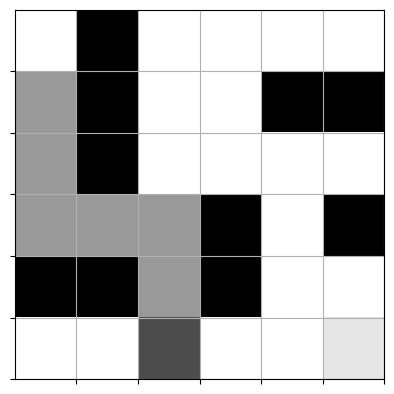

Action: left, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


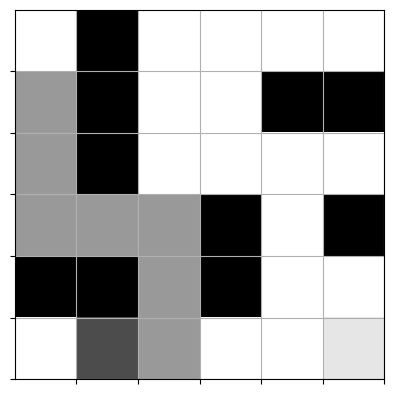

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 19ms/step


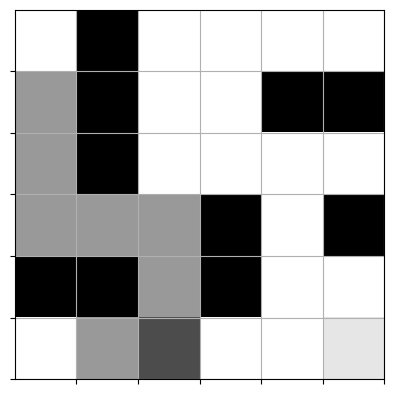

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


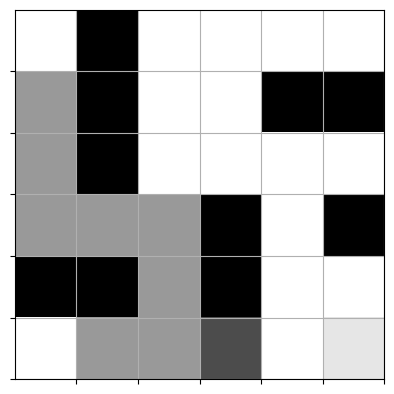

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


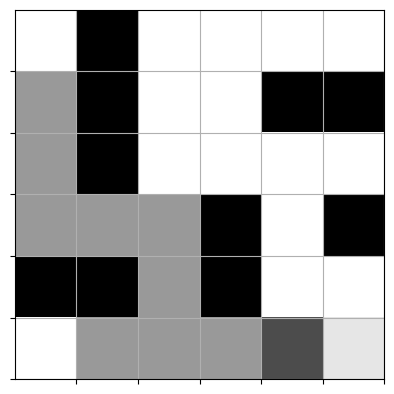

Action: up, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


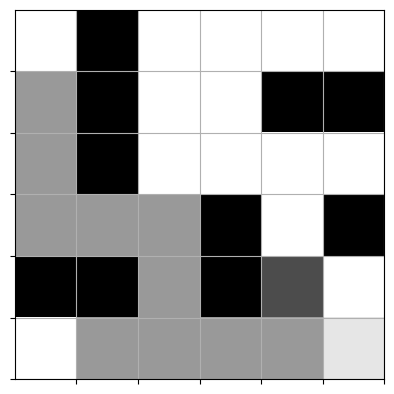

Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


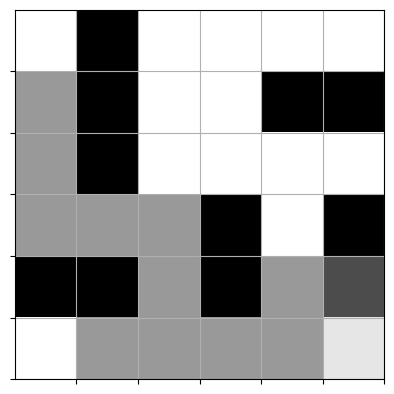

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


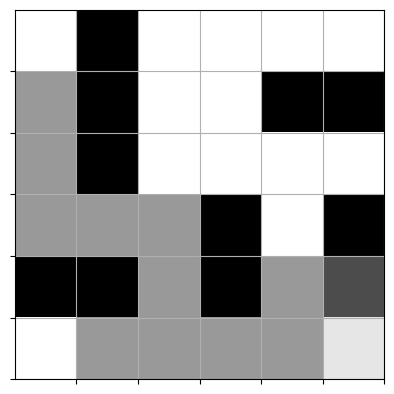

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 19ms/step


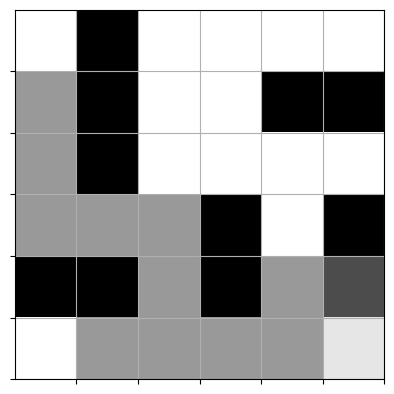

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


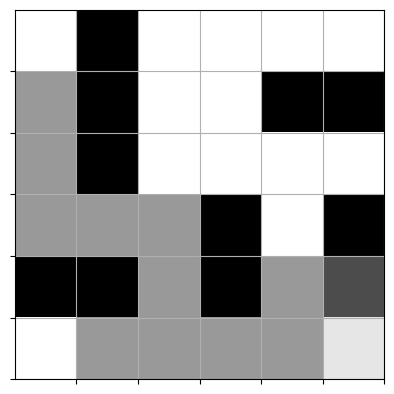

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


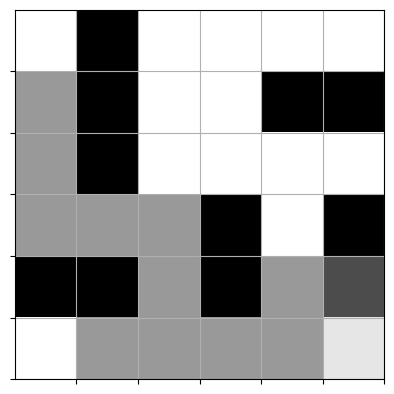

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


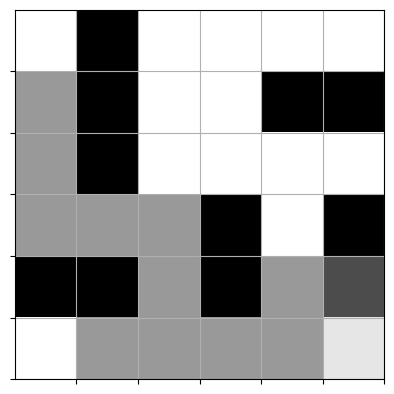

Action: left, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


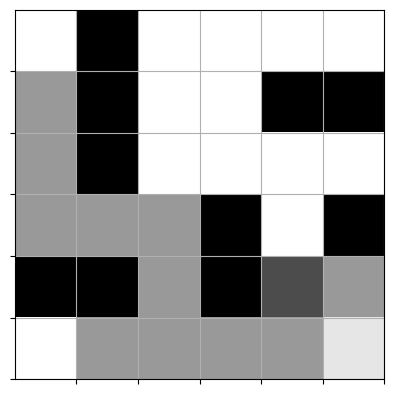

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


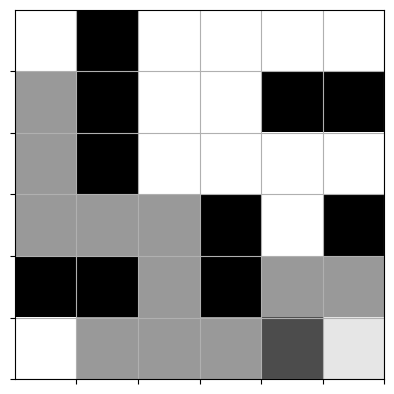

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


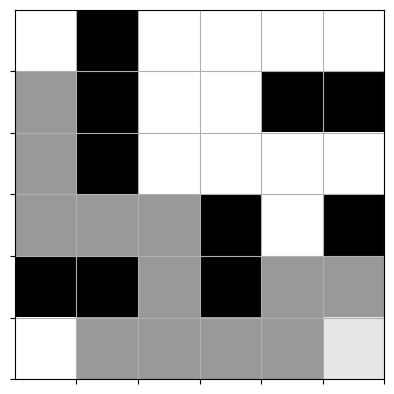

Epoch: 013/99 | Loss: 0.0064 | Episodes: 202 | Win count: 12 | Win rate: 0.000 | time: 9.32 minutes


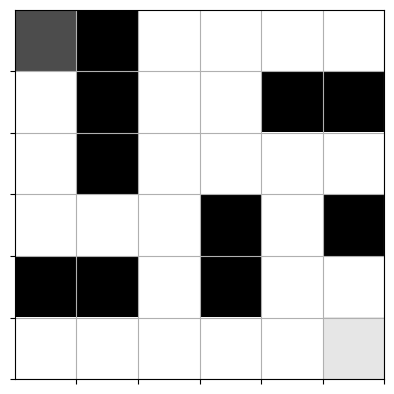

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


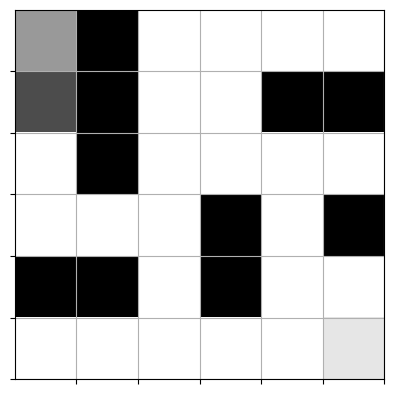

Action: up, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


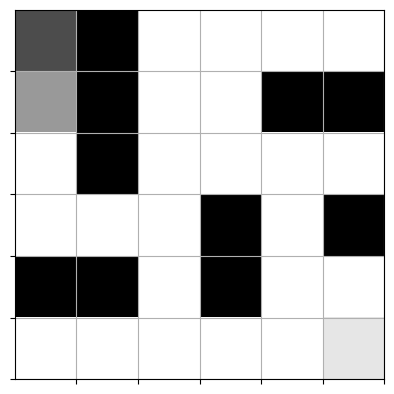

Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


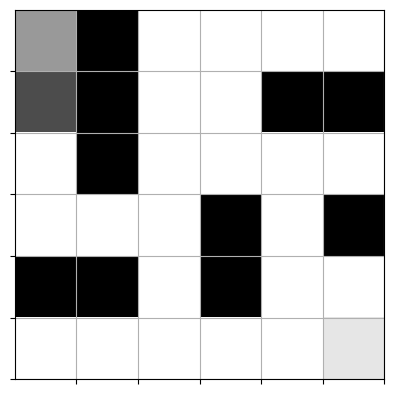

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


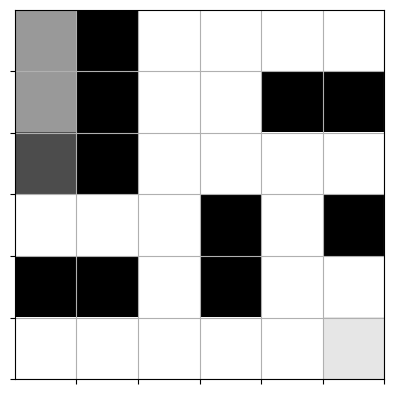

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


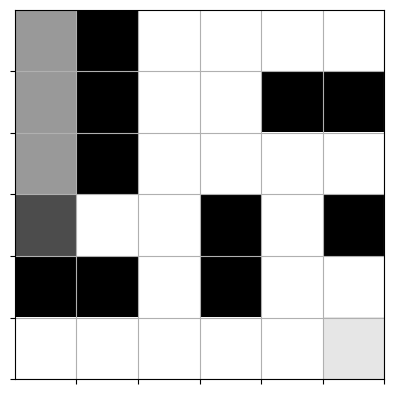

1/1 [==============================] - 0s 18ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


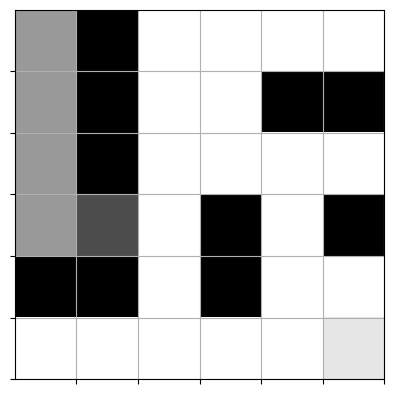

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


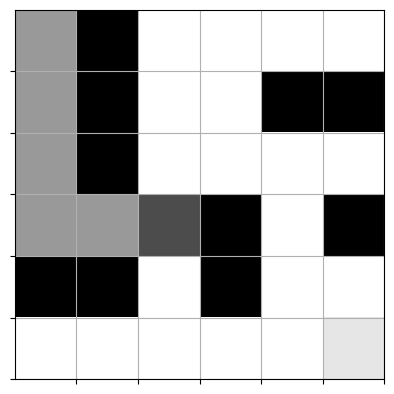

Action: left, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


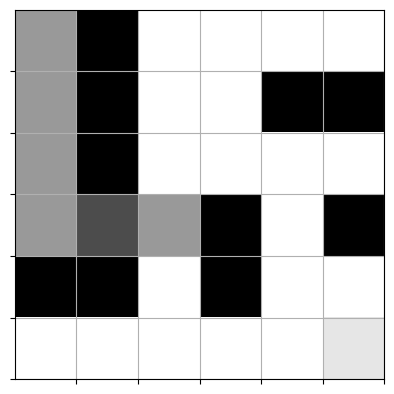

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


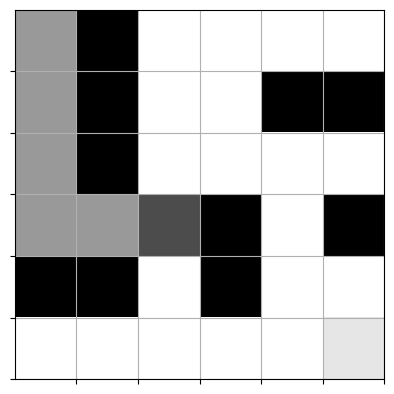

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


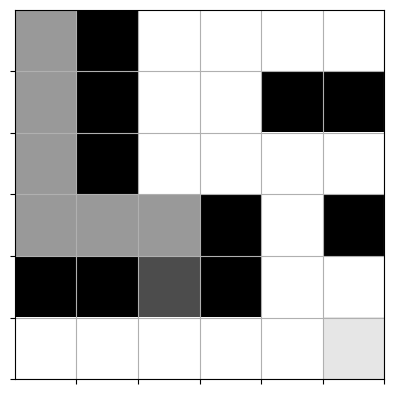

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


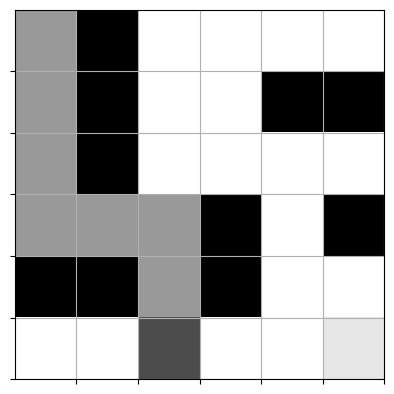

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 14ms/step


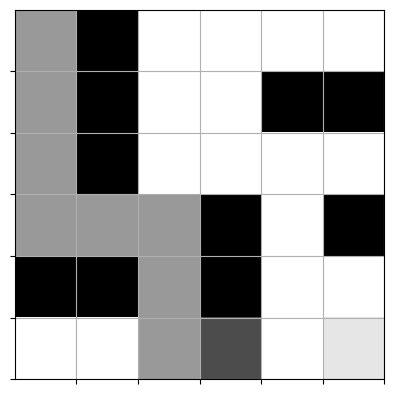

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


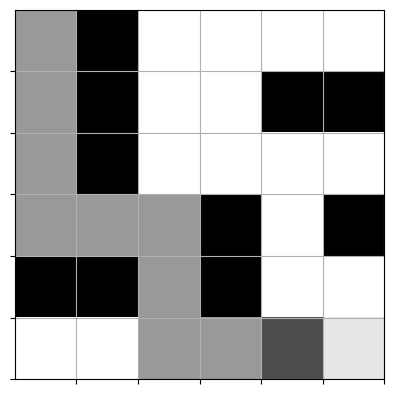

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


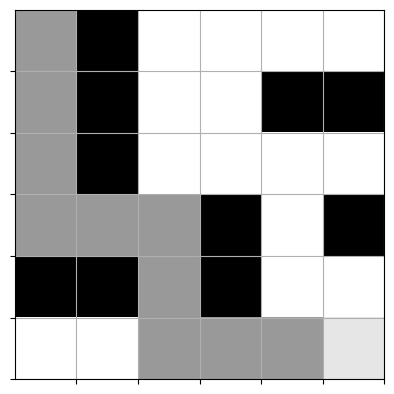

Epoch: 014/99 | Loss: 0.0034 | Episodes: 216 | Win count: 13 | Win rate: 0.000 | time: 10.02 minutes


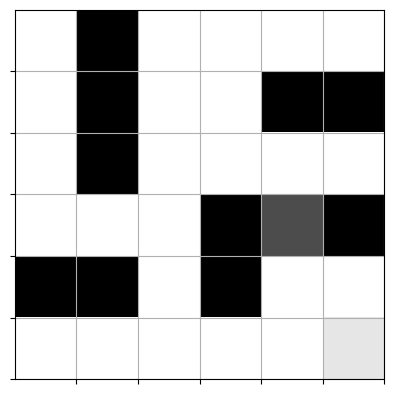

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


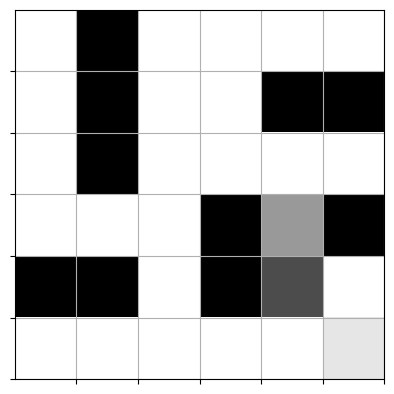

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


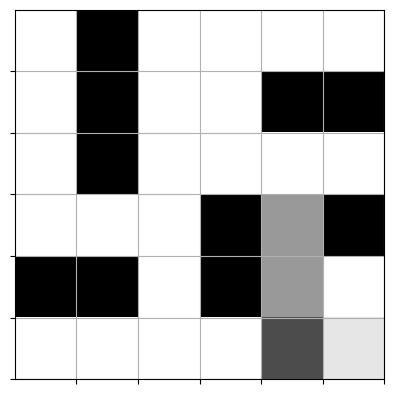

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 15ms/step


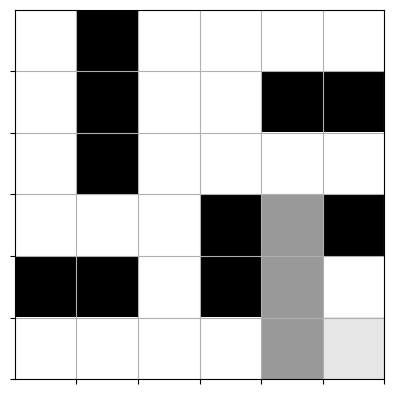

Epoch: 015/99 | Loss: 0.0016 | Episodes: 219 | Win count: 14 | Win rate: 0.000 | time: 10.18 minutes


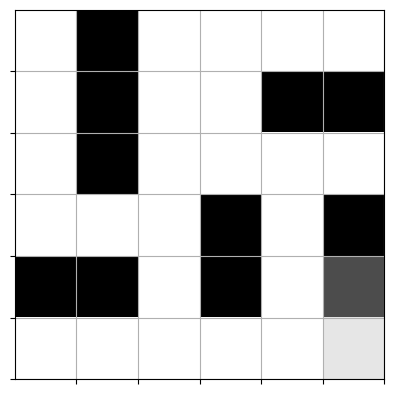

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 1.0
1/1 [==============================] - 0s 17ms/step


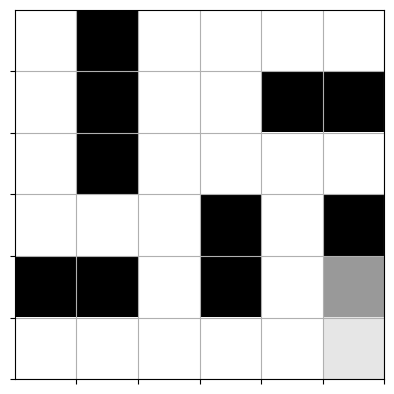

Epoch: 016/99 | Loss: 0.0015 | Episodes: 220 | Win count: 15 | Win rate: 0.000 | time: 10.23 minutes


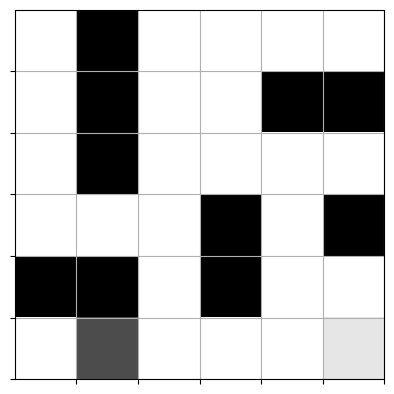

1/1 [==============================] - 0s 18ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


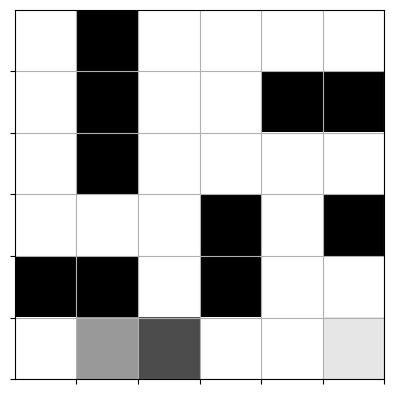

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


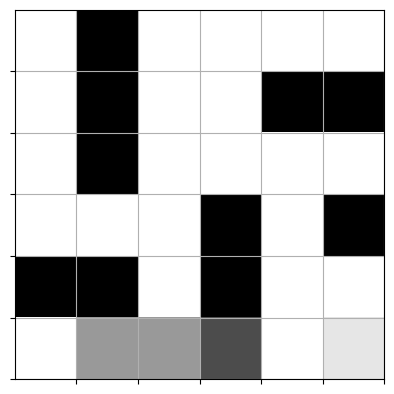

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


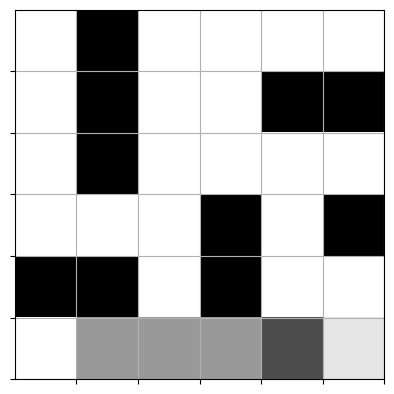

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 15ms/step


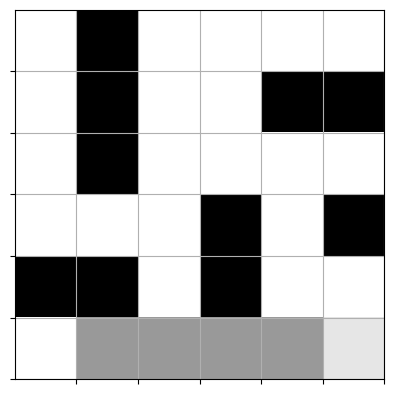

Epoch: 017/99 | Loss: 0.0038 | Episodes: 224 | Win count: 16 | Win rate: 0.000 | time: 10.43 minutes


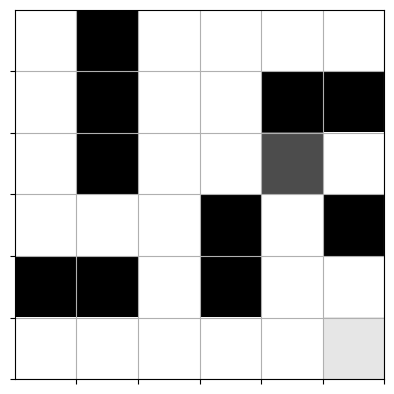

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


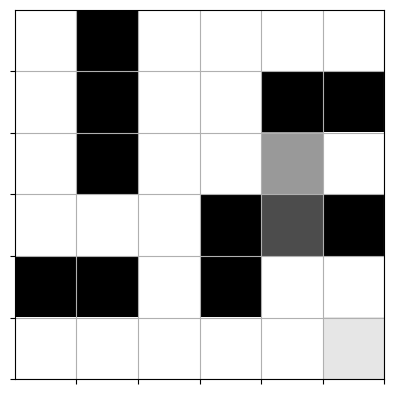

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


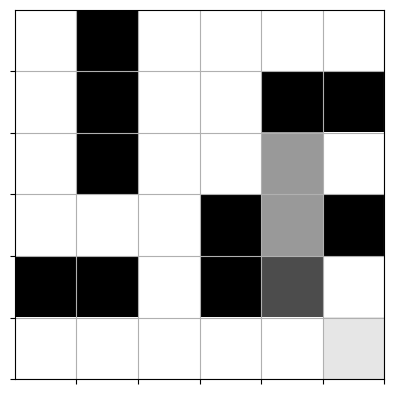

Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


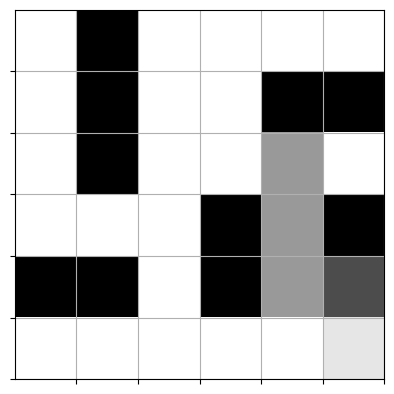

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


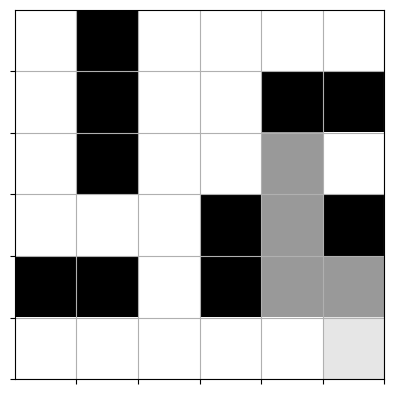

Epoch: 018/99 | Loss: 0.0047 | Episodes: 228 | Win count: 17 | Win rate: 0.944 | time: 10.63 minutes


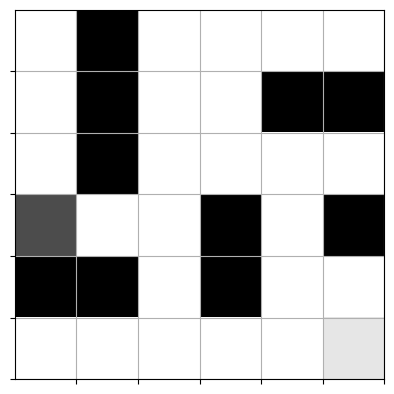

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 19ms/step


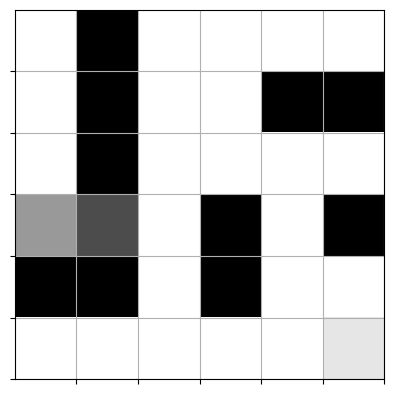

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


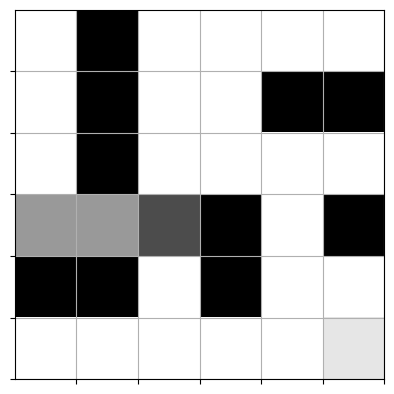

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


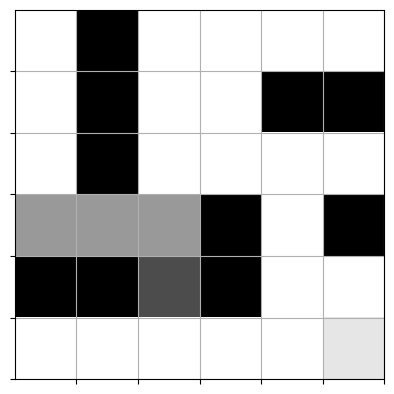

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


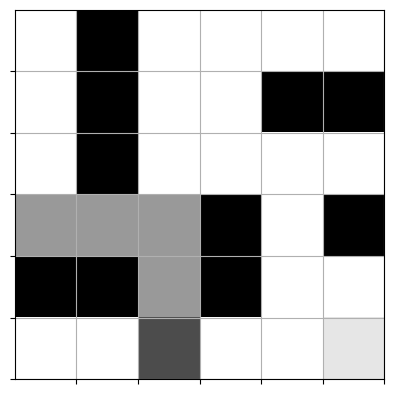

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


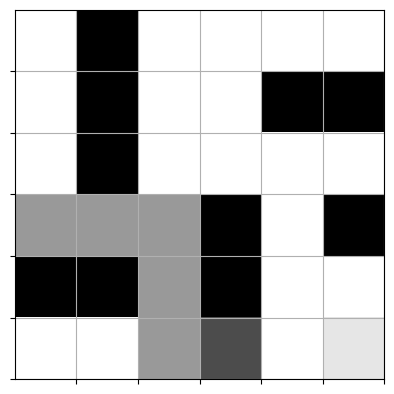

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


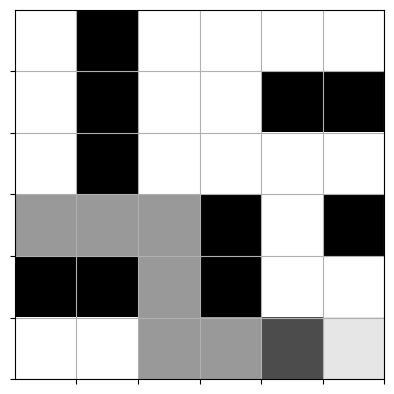

Action: left, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


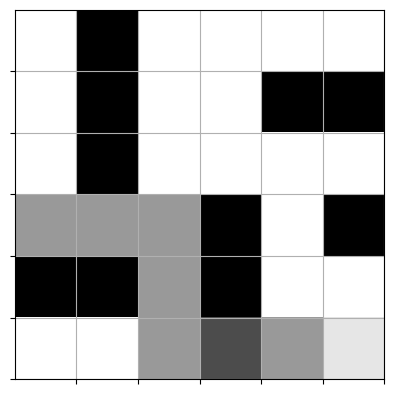

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 20ms/step


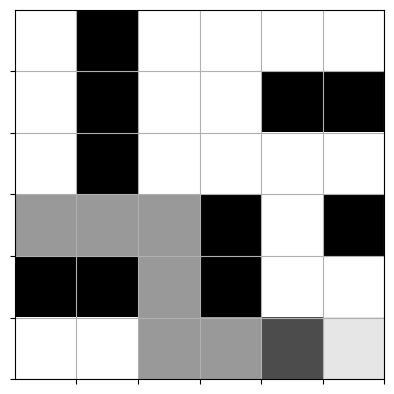

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


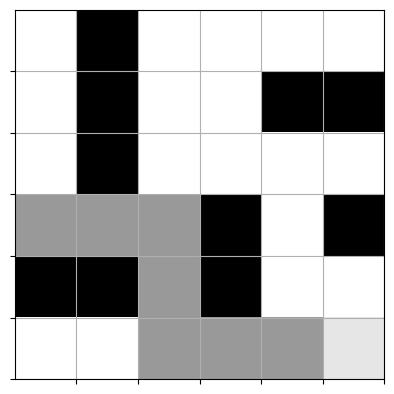

Epoch: 019/99 | Loss: 0.0031 | Episodes: 237 | Win count: 18 | Win rate: 0.944 | time: 11.09 minutes


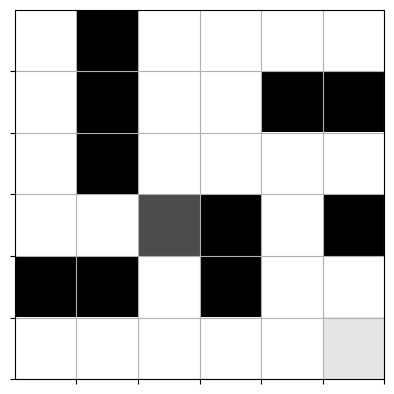

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


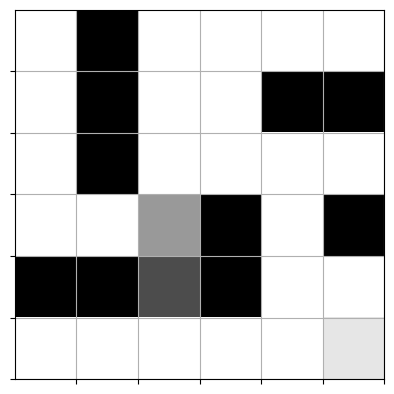

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


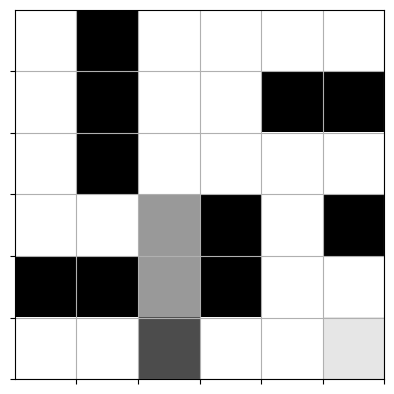

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


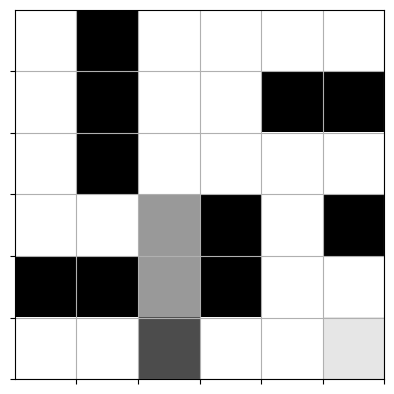

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 14ms/step


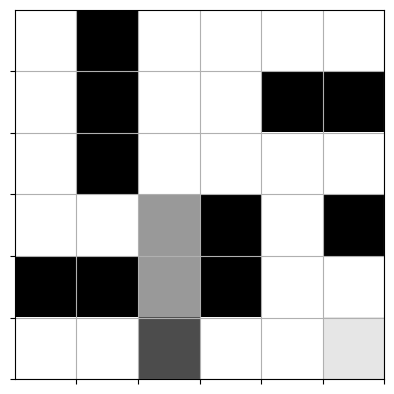

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 17ms/step


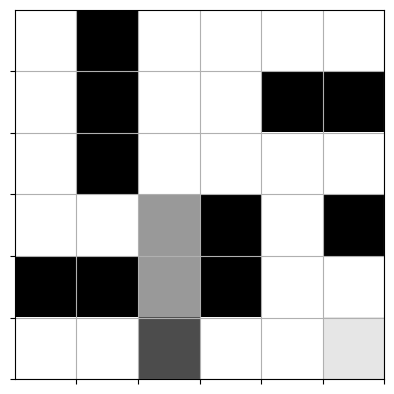

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


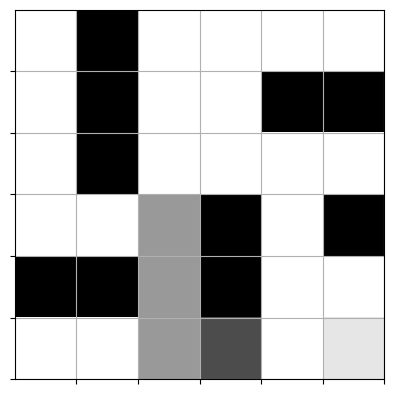

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


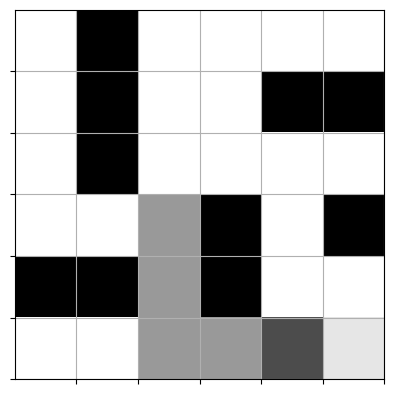

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


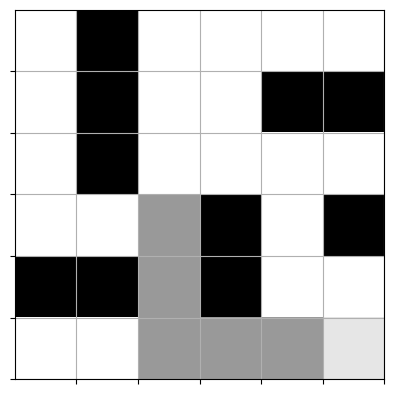

Epoch: 020/99 | Loss: 0.0022 | Episodes: 245 | Win count: 19 | Win rate: 0.944 | time: 11.50 minutes


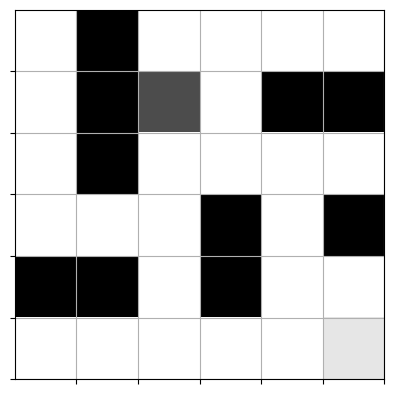

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


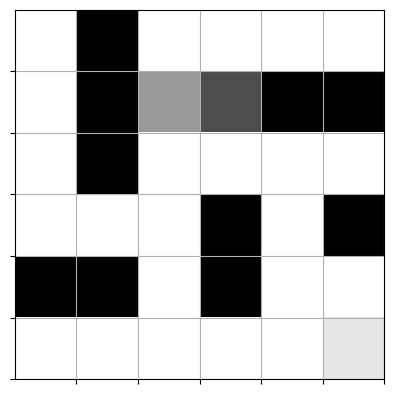

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


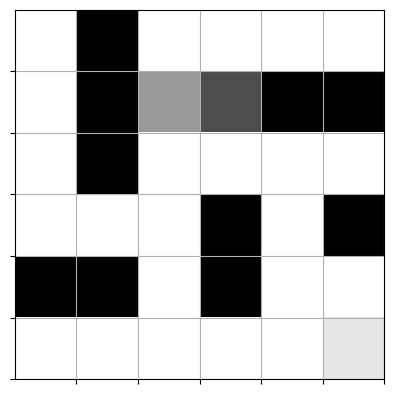

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


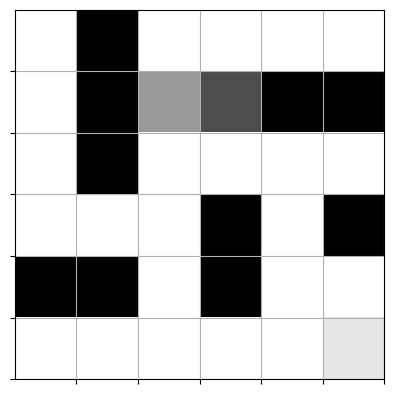

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


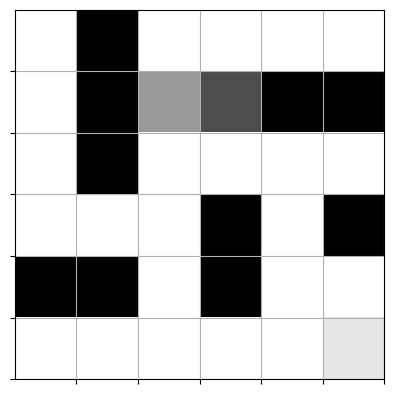

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


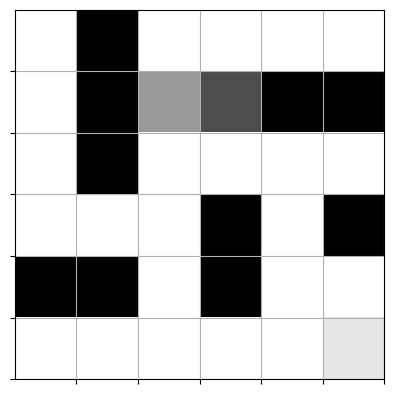

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


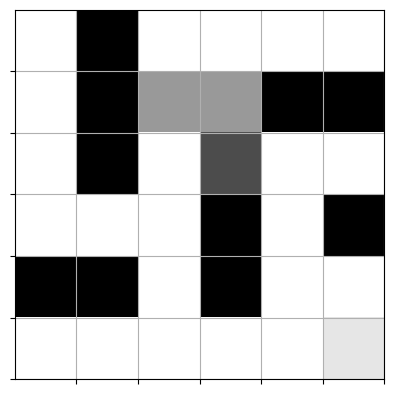

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


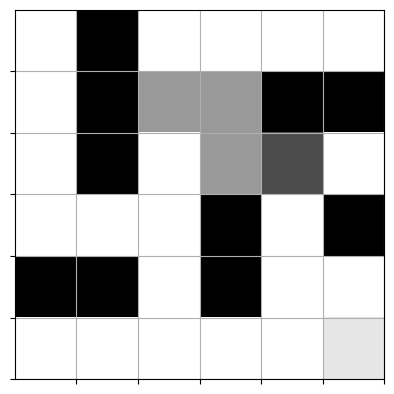

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


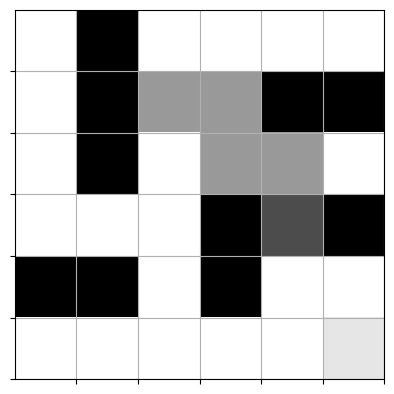

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


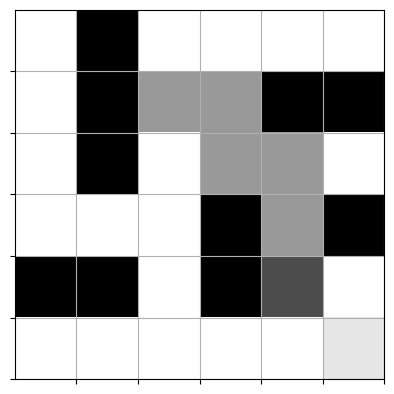

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


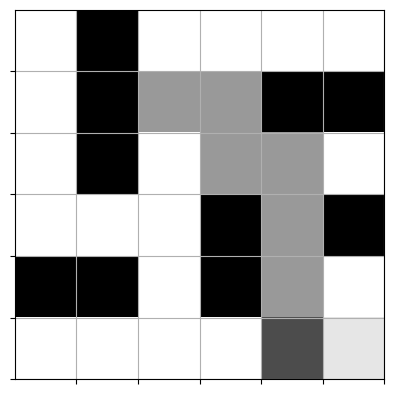

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


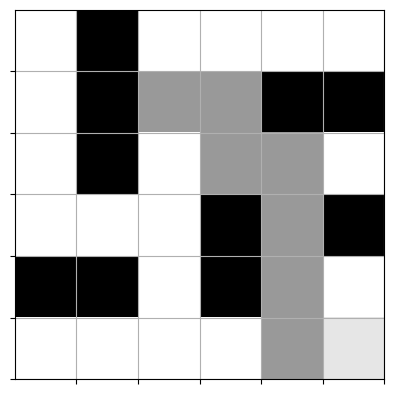

Epoch: 021/99 | Loss: 0.0013 | Episodes: 256 | Win count: 20 | Win rate: 0.944 | time: 12.06 minutes


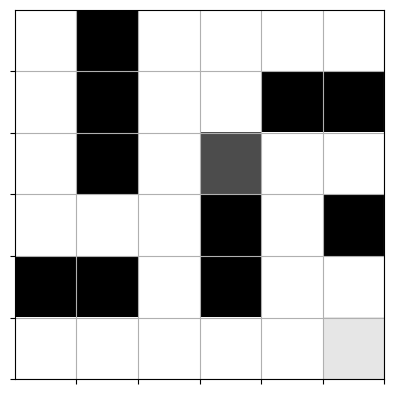

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


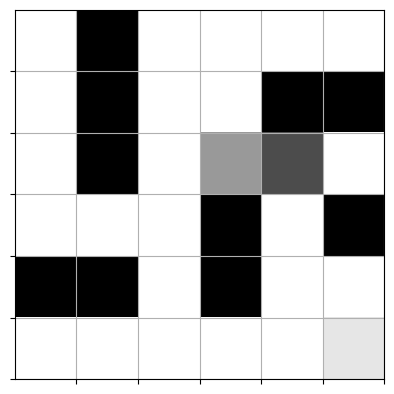

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


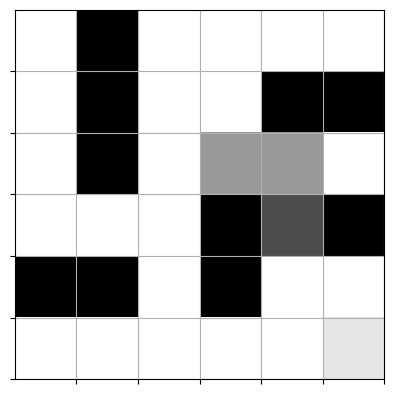

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


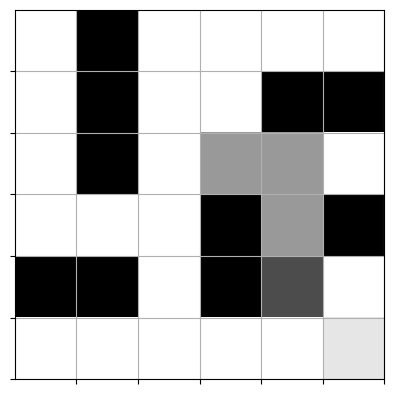

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


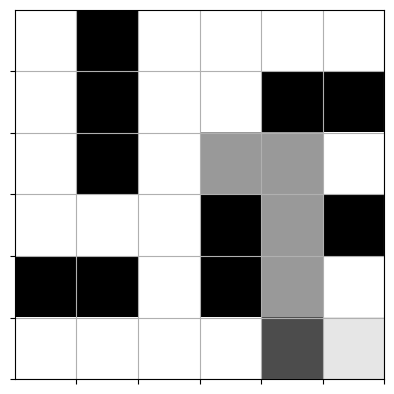

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


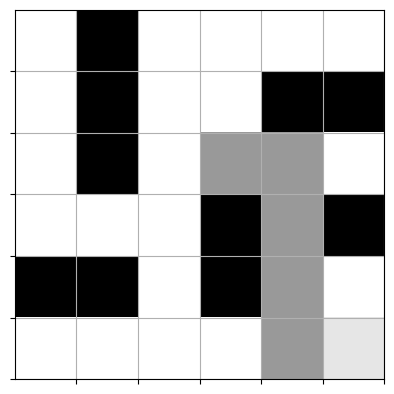

Epoch: 022/99 | Loss: 0.0024 | Episodes: 261 | Win count: 21 | Win rate: 0.944 | time: 12.32 minutes


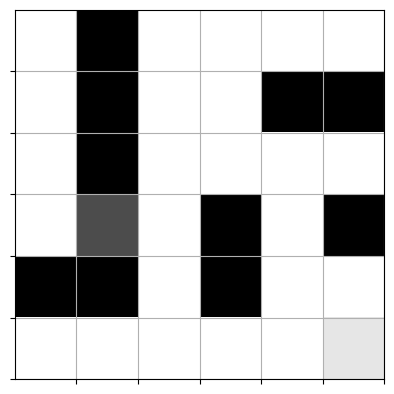

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


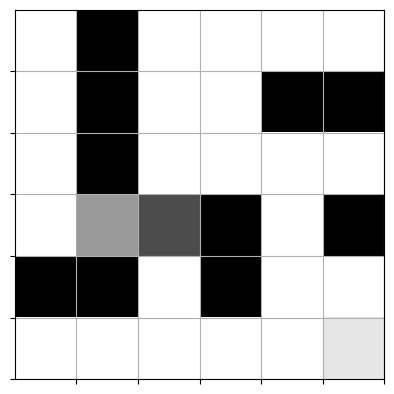

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


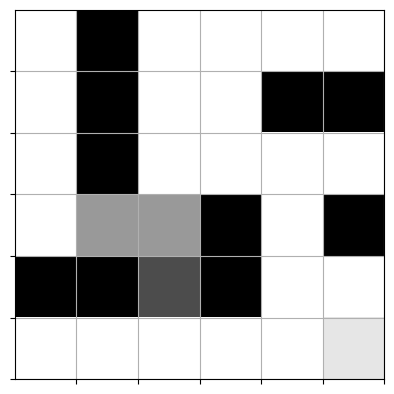

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


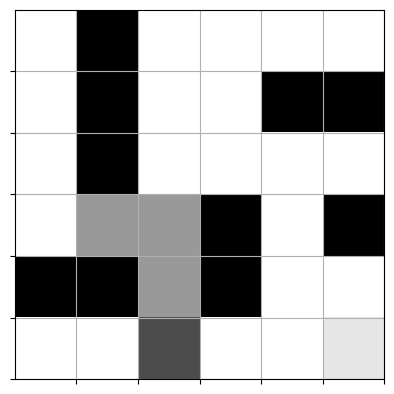

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


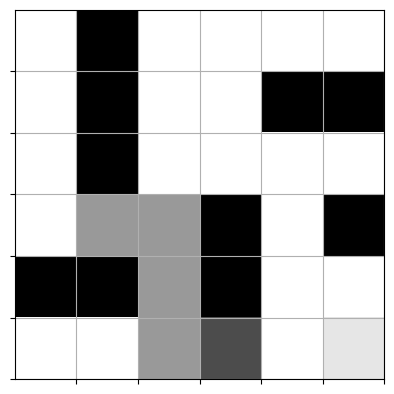

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


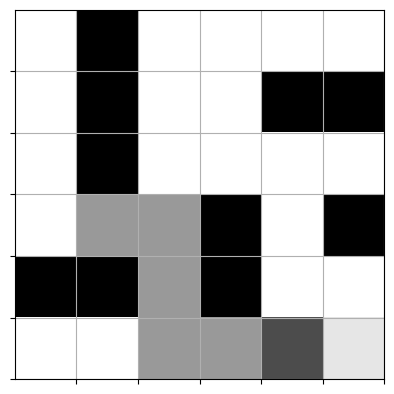

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 17ms/step


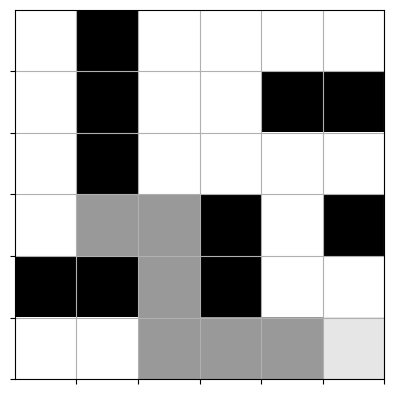

Epoch: 023/99 | Loss: 0.0031 | Episodes: 267 | Win count: 22 | Win rate: 0.944 | time: 12.63 minutes


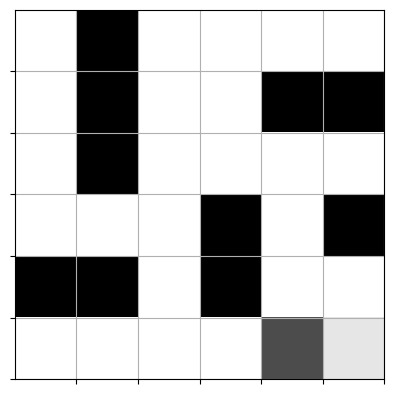

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


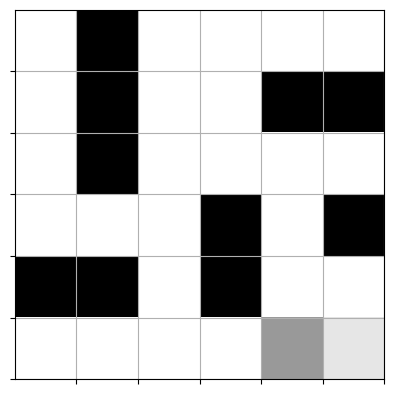

Epoch: 024/99 | Loss: 0.0039 | Episodes: 268 | Win count: 23 | Win rate: 0.944 | time: 12.68 minutes


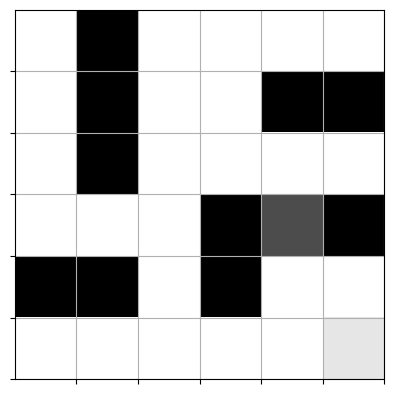

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


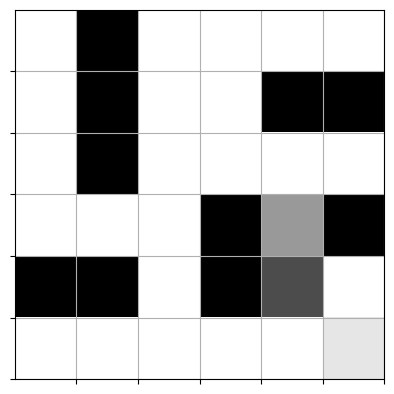

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


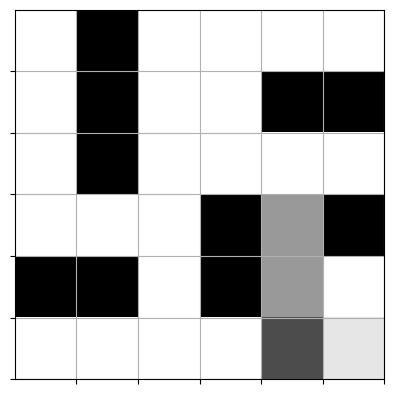

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 20ms/step


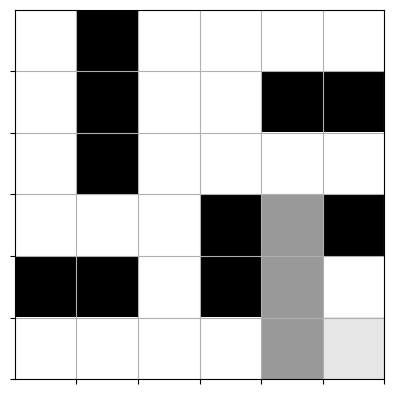

Epoch: 025/99 | Loss: 0.0030 | Episodes: 271 | Win count: 24 | Win rate: 0.944 | time: 12.84 minutes


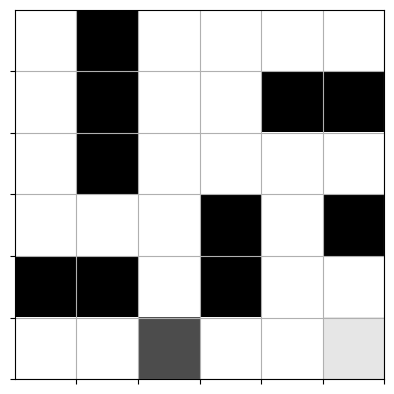

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


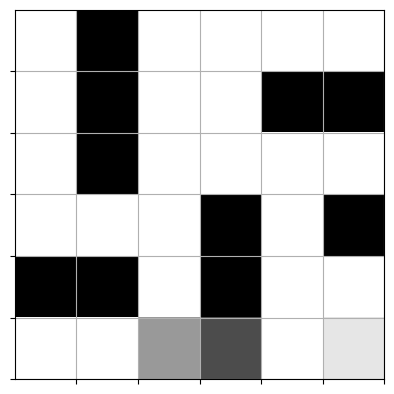

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


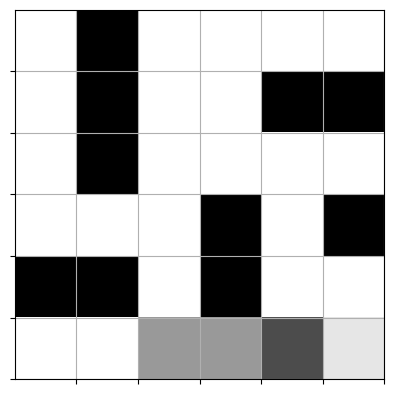

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 17ms/step


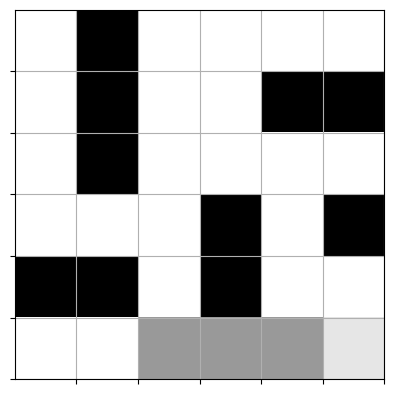

Epoch: 026/99 | Loss: 0.0024 | Episodes: 274 | Win count: 25 | Win rate: 0.944 | time: 13.00 minutes


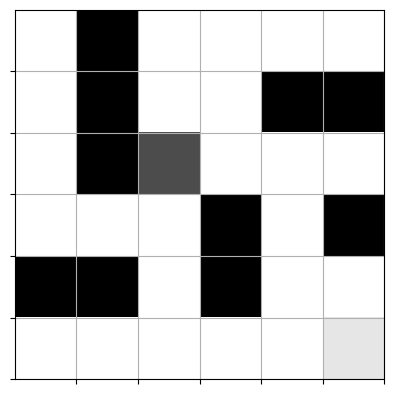

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


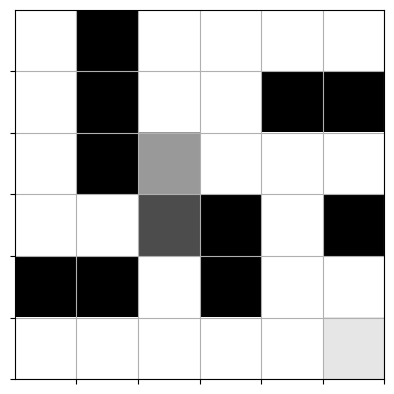

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


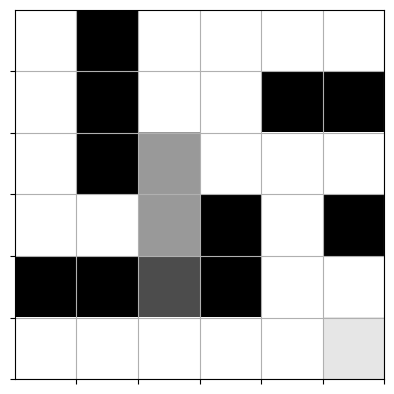

Action: up, Reward: -0.25
1/1 [==============================] - 0s 19ms/step


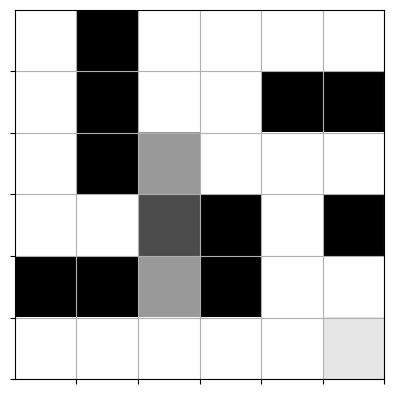

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


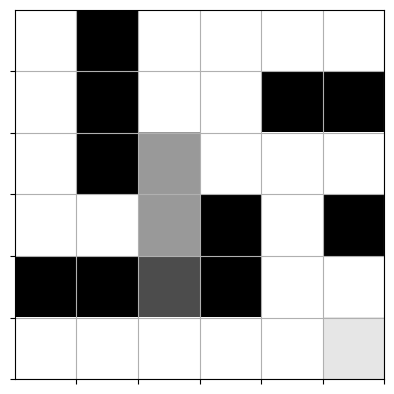

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


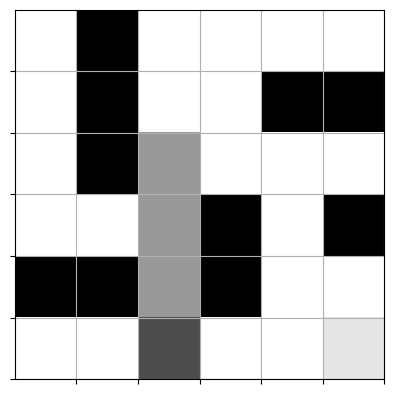

1/1 [==============================] - 0s 17ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


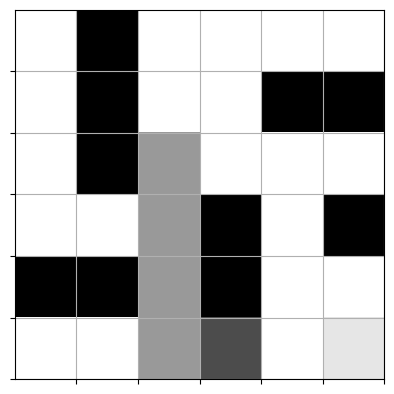

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


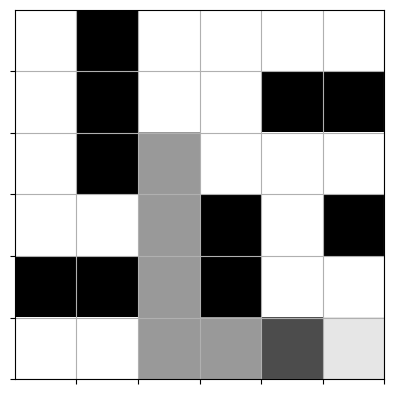

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


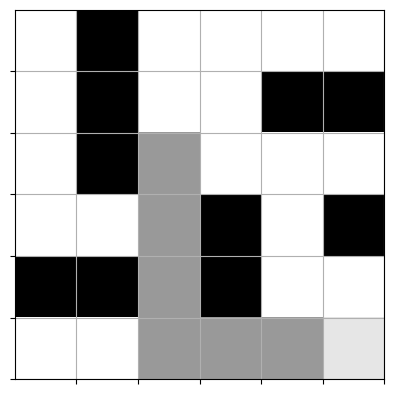

Epoch: 027/99 | Loss: 0.0014 | Episodes: 282 | Win count: 26 | Win rate: 0.944 | time: 13.41 minutes


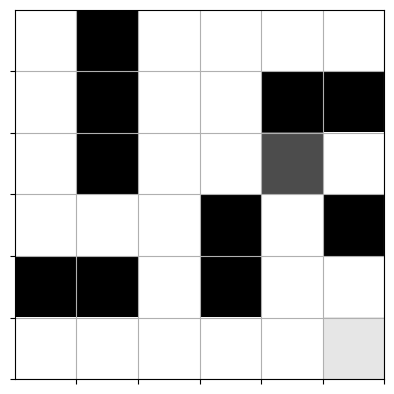

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 17ms/step


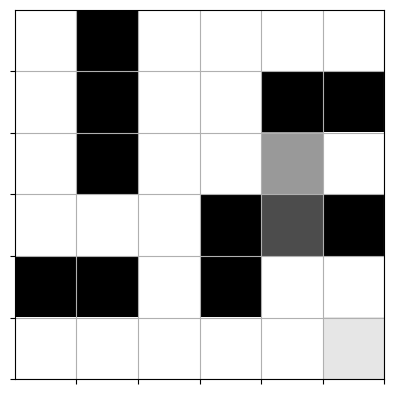

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 19ms/step


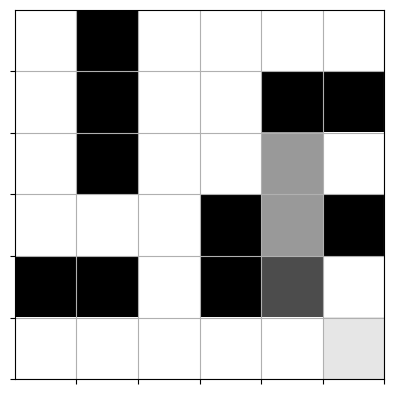

1/1 [==============================] - 0s 16ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


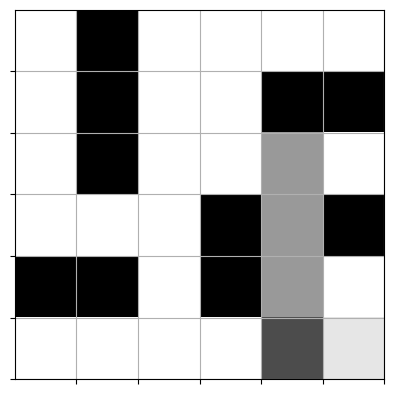

1/1 [==============================] - 0s 14ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 18ms/step


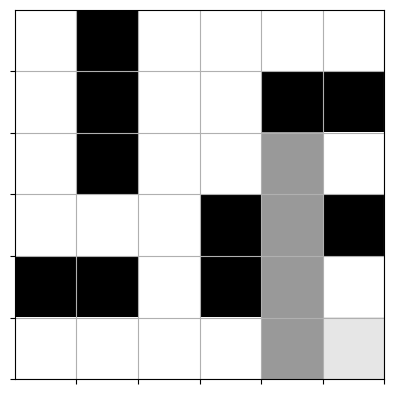

Epoch: 028/99 | Loss: 0.0016 | Episodes: 286 | Win count: 27 | Win rate: 0.944 | time: 13.62 minutes


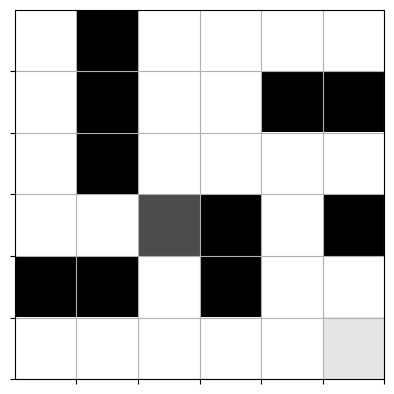

1/1 [==============================] - 0s 17ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 18ms/step


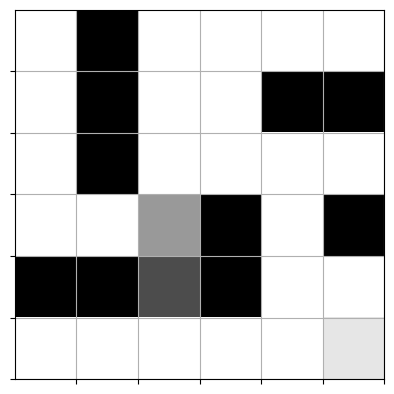

1/1 [==============================] - 0s 15ms/step
Action: down, Reward: 0.04
1/1 [==============================] - 0s 16ms/step


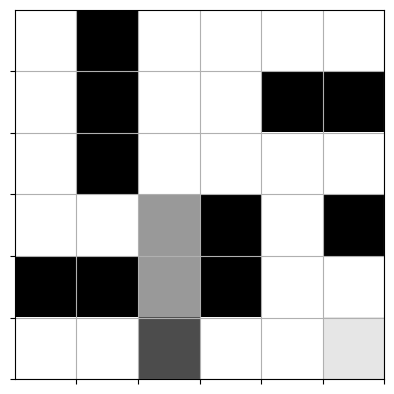

Action: up, Reward: -0.25
1/1 [==============================] - 0s 16ms/step


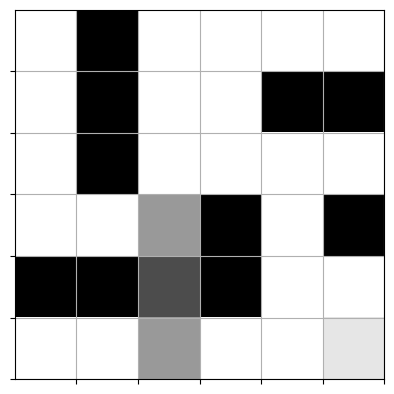

1/1 [==============================] - 0s 14ms/step
Action: down, Reward: -0.25
1/1 [==============================] - 0s 15ms/step


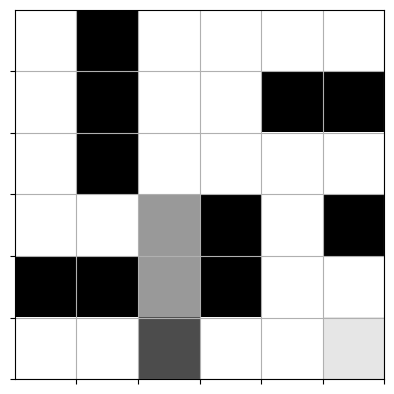

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


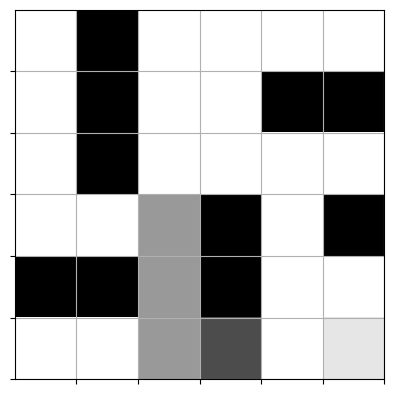

1/1 [==============================] - 0s 16ms/step
Action: right, Reward: 0.04
1/1 [==============================] - 0s 15ms/step


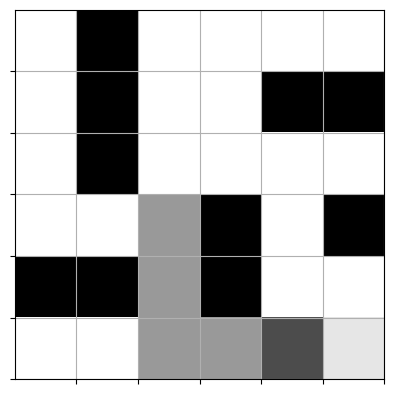

1/1 [==============================] - 0s 15ms/step
Action: right, Reward: 1.0
1/1 [==============================] - 0s 16ms/step


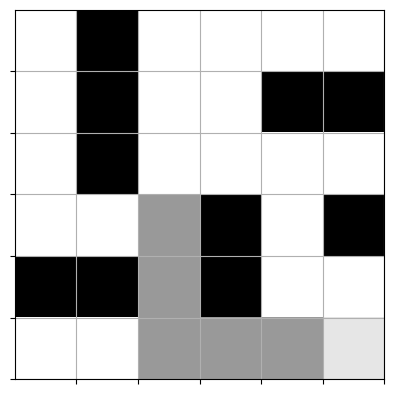

Epoch: 029/99 | Loss: 0.0010 | Episodes: 288 | Win count: 28 | Win rate: 1.000 | time: 13.97 minutes
Reached 100% win rate at epoch: 29


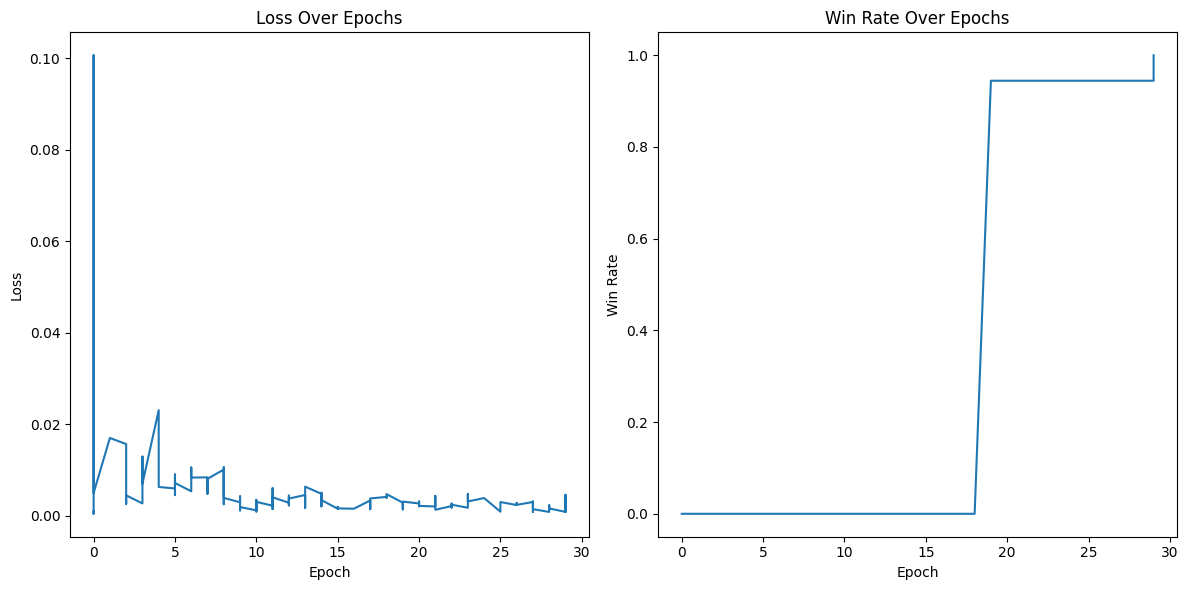

Files: C:\Users\Legion\Desktop\New folder\model.h5, C:\Users\Legion\Desktop\New folder\model.json
n_epoch: 29, max_mem: 288, data: 32, time: 13.98 minutes


838.675104

In [61]:
# Train the model
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)


In [72]:
########run the program from model saved in filesystem

from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the Qmaze class and other necessary functions here
# ...

# Constants for visualization
visited_mark = 0.6
agent_mark = 0.3

# Load the trained model from your computer's hard disk
model = load_model(r'C:\Users\Legion\Desktop\New folder\model.keras')

# Function to draw the maze and agent's position
def draw_maze_with_agent(qmaze):
    nrows, ncols = qmaze.maze.shape
    canvas = np.copy(qmaze.maze)
    for r, c in qmaze.visited:
        canvas[r, c] = visited_mark
    agent_row, agent_col, _ = qmaze.state
    canvas[agent_row, agent_col] = agent_mark
    canvas[nrows - 1, ncols - 1] = 1.0  # Cheese cell

    plt.grid('on')
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.show()



from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


# Define the Qmaze class and other necessary functions here
# ...

# Constants for visualization
visited_mark = 0.6
agent_mark = 0.3

# Define the directory where you want to save the maze images
output_directory = r'C:\Users\Legion\Desktop\New folder\images'

# Load the trained model from your computer's hard disk
model = load_model(r'C:\Users\Legion\Desktop\New folder\model.keras')

# Function to draw the maze and agent's position
def draw_maze_with_agent(qmaze, step_number):
    nrows, ncols = qmaze.maze.shape
    canvas = np.copy(qmaze.maze)
    for r, c in qmaze.visited:
        canvas[r, c] = visited_mark
    agent_row, agent_col, _ = qmaze.state
    canvas[agent_row, agent_col] = agent_mark
    canvas[nrows - 1, ncols - 1] = 1.0  # Cheese cell

    plt.grid('on')
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.imshow(canvas, interpolation='none', cmap='gray')
    plt.savefig(os.path.join(output_directory, f'step_{step_number}.png'))
    plt.close()

# Function to test a trained model with the maze
def test_trained_model_with_images(model, maze):
    qmaze = Qmaze(maze)
    step_number = 0

    while True:
        agent_cell = (2, 3)  # Start from the beginning
        qmaze.reset(agent_cell)

        while True:
            # Create an image of the current step and display it
            draw_maze_with_agent(qmaze, step_number)
            step_number += 1

            # Get the current state
            envstate = qmaze.observe()

            # Predict the best action to take using the trained model
            action = np.argmax(model.predict(envstate))

            # Perform the predicted action
            _, reward, game_status = qmaze.act(action)

            print(f"Step: {step_number} - Reward: {reward} - Status: {game_status}")

            if game_status == 'win' or game_status == 'lose':
                break

        # Ask if you want to run another test
        another_test = input("Do you want to run another test (y/n)? ")
        if another_test.lower() != 'y':
            break

# Load the maze or create it as in your previous code
maze = np.array([
    [1., 0., 1., 1., 1., 1. ],
    [1., 0., 1., 1., 0., 0. ],
    [1., 0., 1., 1., 1., 1. ],
    [1., 1., 1., 0., 1., 0. ],
    [0., 0., 1., 0., 1., 1. ],
    [1., 1., 1., 1., 1., 1. ]
])

# Call the test function with the trained model and maze
test_trained_model_with_images(model, maze)

1/1 [==============================] - 0s 50ms/step
Step: 1 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 18ms/step
Step: 2 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 16ms/step
Step: 3 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 17ms/step
Step: 4 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 15ms/step
Step: 5 - Reward: 1.0 - Status: win


Do you want to run another test (y/n)?  y


1/1 [==============================] - 0s 14ms/step
Step: 6 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 14ms/step
Step: 7 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 15ms/step
Step: 8 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 15ms/step
Step: 9 - Reward: 0.04 - Status: not_over
1/1 [==============================] - 0s 16ms/step
Step: 10 - Reward: 1.0 - Status: win


Do you want to run another test (y/n)?  n


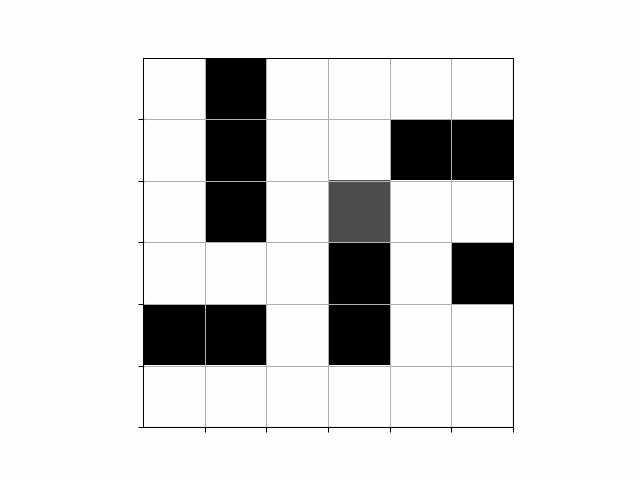

In [73]:
# make a gif




from PIL import Image, ImageSequence
import os
from IPython.display import display, Image as IPImage

# Function to create a GIF from the saved images with a specified frame duration
def create_gif(image_directory, gif_filename, frame_duration):
    images = []
    for filename in sorted(os.listdir(image_directory)):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(image_directory, filename))
            images.append(img)

    # Save the images as a GIF with the specified frame duration
    images[0].save(gif_filename, save_all=True, append_images=images[1:], loop=0, duration=int(frame_duration * 1000))

# Call the create_gif function to create the GIF
image_directory = 'C:/Users/Legion/Desktop/New folder/images'
gif_filename = 'maze_steps.gif'
frame_duration = 0.5  # Adjust the frame duration as needed (in seconds)
create_gif(image_directory, gif_filename, frame_duration)

# Display the GIF in the notebook
with open(gif_filename, 'rb') as file:
    display(IPImage(data=file.read(), format="png"))